# KPI Report Pre vs Post 5G Launch (in May 2022)
- Active Users Trend
- Revenue Growth Trend
- Recover Active User Rate & Revenue by optimizing Plans

# Installing Dependencies

In [2]:
pip_list = !pip list
packages = ["chardet", "dabl", "imblearn", "keras-tuner", "mysql-connector-python", "numpy", "pandas", "sklearn", "statsmodels", "tensorflow", "xgboost"]
for package in packages:
    if not pip_list.grep(package):
        !pip3 install {package}

print("Package installations completed.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.9/563.9 kB 2.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 26.2 MB/s eta 0:00:0000:0100:01
Package installations completed.


# Importing Libraries

In [3]:
import calendar
import datetime
import os
import shutil
import warnings
from pickle import dump

import chardet
import matplotlib.pyplot as plt
import mysql.connector
import numpy as np
import pandas as pd
import requests
import scipy.stats as stat
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
from dabl import SimpleClassifier, SimpleRegressor, clean, plot
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from IPython.display import display
from keras_tuner.tuners import BayesianOptimization, Hyperband, RandomSearch
from mysql.connector import errorcode
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import (SelectPercentile, VarianceThreshold,
                                       chi2, f_classif)
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.model_selection import (RandomizedSearchCV, StratifiedKFold,
                                     train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (MinMaxScaler, OneHotEncoder, OrdinalEncoder,
                                   StandardScaler)
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib
from xgboost import XGBClassifier, XGBRegressor

%matplotlib inline
time_stamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
set_config(display="diagram", print_changed_only=False)
pd.set_option("display.float_format", lambda f: "%.2f" % f)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
plt.rc("axes", labelsize=12)
plt.rc("axes", titlesize=12)
plt.rc("font", size=10)
plt.rcParams["figure.figsize"] = [18, 7]
plt.style.use("dark_background")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings("ignore")

print(device_lib.list_local_devices())
print(tf.config.list_physical_devices("GPU"))
print(tf.test.gpu_device_name())
print(os.system("cat /proc/cpuinfo | grep 'model name'"))
print(os.system("cat /proc/meminfo | grep 'MemTotal'"))
print(os.system("nvidia-smi"))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10710164697236838948
]
[]

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
0
MemTotal:       32880876 kB
0
32512


sh: 1: nvidia-smi: not found


# Connecting to SQL

In [4]:
# try:
#     conn = mysql.connector.connect(
#         user="user_name",
#         password=os.environ["CONN_STR"],
#         host="mysqlserver.mysql.database.azure.com",
#         port=3306,
#         database="",
#         ssl_ca="{ca-cert filename}",
#         ssl_disabled=False,
#     )
#     print("Connection established")
# except mysql.connector.Error as e:
#     if e.errno == errorcode.ER_ACCESS_DENIED_ERROR:
#         print("Something is wrong with the user name or password")
#     elif e.errno == errorcode.ER_BAD_DB_ERROR:
#         print("Database does not exist")
#     else:
#         print(e)
# else:
#     tables = {table: pd.read_sql(f"""SELECT * FROM {table};""", conn) for table in pd.read_sql("SHOW TABLES", conn).iloc[:, 0]}
#     for table_name, table_dataframe in tables.items():
#         print(f"-------------------------------------------------------\nTable: {table_name}")
#         display(table_dataframe)
#     conn.close()
#     print(f"Discovered table(s): {len(tables)}.\nDB Connection closed.")

# Reading Tables

In [5]:
url = "https://raw.githubusercontent.com/lyoh001/AzureML/main"
df_dim_cities = pd.read_csv(f"{url}/dim_cities.csv", delimiter=",", thousands=",")
df_dim_date = pd.read_csv(f"{url}/dim_date.csv", delimiter=",", thousands=",")
df_dim_plan = pd.read_csv(f"{url}/dim_plan.csv", delimiter=",", thousands=",")
df_fact_atliqo_metrics = pd.read_csv(f"{url}/fact_atliqo_metrics.csv", delimiter=",", thousands=",")
df_fact_market_share = pd.read_csv(f"{url}/fact_market_share.csv", delimiter=",", thousands=",")
df_fact_plan_revenue = pd.read_csv(f"{url}/fact_plan_revenue.csv", delimiter=",", thousands=",")
description = [
    "Column Description for dim_cities:\n1. city_code: This column represents the unique code given for each city.\n2. city_name: This column represents the name of the city corresponding to the city code.",
    "Column Description for dim_date:\n1. date: This column represents the starting date of each month. \n2. month_name: This column represents the month names in abbreviated form(Example: Jan, Feb, Mar, etc). We have months starting from January to September except for May.\n3. before/after_5g: This column represents the unique category based on the month. We have 2 categories, Before 5G and After 5G. January to April comes represents the period before 5G implementation and June to September represents periods after 5G implementation.\n4. time_period: This column represents the unique sequence number ranging from 1 to 4. These time Periods are used to make respective months comparisons before and after 5G implementation (Example: Jan vs Jun, Feb vs Jul, Mar vs Aug and Apr vs Sep)",
    "Column Description for dim_plan:\n1. plan: This column represents the various internet plans provided by the Atliqo company to the users. \n2. plan_description: This column represents the brief description about the internet plan.",
    "Column Description for fact_atliqo_metrics:\n1. date: This column represents the starting date of each month.\n2. city_code: This column represents the unique pincode code given for each city.\n3. company: This column represents the company name for which the data is provided. In this dataset it's only Atliqo. \n4. atliqo_revenue_crores: This column represents the revenue that Atliqo got on that particular month in that city_code in crores.\n5. arpu: This column represents the average revenue per user. That means on average how much revenue Atliqo generated on single user for a given time period.\n6. active_users_lakhs: This column represents the number of active users who are using Atliqo's service on that particular month in that city_code in lakhs.\n7. unsubscribed_users_lakhs: This column represents the number of unsubscribed users who unsubscribed from Atliqo on that particular month in that city_code in lakhs.",
    "Column Description for fact_market_share:\n1. date: This column represents the starting date of each month.\n2. city_code: This column represents the unique code given for each city.\n3. tmv_city_crores: This column represents the total market value of the city in that month in crores.\n4. company: This column represents the different competitor names in the telecom industry [Atliqo, Britel, DADAFONE, PIO, Others].\n5. ms_pct: This column represents the percentage of market share gained by respective company from the total market value(tmv_city) on that particular month in that city-code.",
    "Column Description for fact_plan_revenue:\n1. date: This column represents the starting date of each month.\n2. city_code: This column represents the unique code given for each city.\n3. plans: This column represents the various internet plans provided by the Atliqo company to the users.\n4. plan_revenue_crores: This column represents the revenue that Atliqo got from that respective plan on that particular month in that city_code in crores.",
]
for desc, df_temp in zip(
    description,
    [
        df_dim_cities,
        df_dim_date,
        df_dim_plan,
        df_fact_atliqo_metrics,
        df_fact_market_share,
        df_fact_plan_revenue,
    ],
):
    print(f"-------------------------------------------------------\n{desc}\n-------------------------------------------------------\nColumn Nunique:")
    df_temp = df_temp.copy()
    for i, col in enumerate(df_temp.columns):
        print(f"{i+1}. {col}: {df_temp[col].nunique()}")
    display(df_temp)

-------------------------------------------------------
Column Description for dim_cities:
1. city_code: This column represents the unique code given for each city.
2. city_name: This column represents the name of the city corresponding to the city code.
-------------------------------------------------------
Column Nunique:
1. city_code: 15
2. city_name: 15


,city_code,city_name
0,400001,Mumbai
1,110001,Delhi
2,700001,Kolkata
3,560001,Bangalore
4,600001,Chennai
5,500001,Hyderabad
6,411001,Pune
7,380001,Ahmedabad
8,302001,Jaipur
9,226001,Lucknow


-------------------------------------------------------
Column Description for dim_date:
1. date: This column represents the starting date of each month. 
2. month_name: This column represents the month names in abbreviated form(Example: Jan, Feb, Mar, etc). We have months starting from January to September except for May.
3. before/after_5g: This column represents the unique category based on the month. We have 2 categories, Before 5G and After 5G. January to April comes represents the period before 5G implementation and June to September represents periods after 5G implementation.
4. time_period: This column represents the unique sequence number ranging from 1 to 4. These time Periods are used to make respective months comparisons before and after 5G implementation (Example: Jan vs Jun, Feb vs Jul, Mar vs Aug and Apr vs Sep)
-------------------------------------------------------
Column Nunique:
1. date: 8
2. month_name: 8
3. before/after_5g: 2
4. time_period: 4


,date,month_name,before/after_5g,time_period
0,01-Jan-22,Jan,Before 5G,1
1,01-Feb-22,Feb,Before 5G,2
2,01-Mar-22,Mar,Before 5G,3
3,01-Apr-22,Apr,Before 5G,4
4,01-Jun-22,Jun,After 5G,1
5,01-Jul-22,Jul,After 5G,2
6,01-Aug-22,Aug,After 5G,3
7,01-Sep-22,Sep,After 5G,4


-------------------------------------------------------
Column Description for dim_plan:
1. plan: This column represents the various internet plans provided by the Atliqo company to the users. 
2. plan_description: This column represents the brief description about the internet plan.
-------------------------------------------------------
Column Nunique:
1. plan: 13
2. plan_description: 13


,plan,plan_description
0,p1,Smart Recharge Pack (2 GB / Day Combo For 3 mo...
1,p2,Super Saviour Pack (1.5 GB / Day Combo For 56 ...
2,p3,Elite saver Pack (1 GB/ Day) Valid: 28 Days
3,p4,Mini Data Saver Pack (500 MB/ Day) Valid: 20 Days
4,p5,Rs. 99 Full Talktime Combo Pack
5,p6,Xstream Mobile Data Pack: 15GB Data | 28 days
6,p7,25 GB Combo 3G / 4G Data Pack
7,p8,Daily Saviour (1 GB / Day) validity: 1 Day
8,p9,Combo TopUp: 14.95 Talktime and 300 MB data
9,p10,Big Combo Pack (6 GB / Day) validity: 3 Days


-------------------------------------------------------
Column Description for fact_atliqo_metrics:
1. date: This column represents the starting date of each month.
2. city_code: This column represents the unique pincode code given for each city.
3. company: This column represents the company name for which the data is provided. In this dataset it's only Atliqo. 
4. atliqo_revenue_crores: This column represents the revenue that Atliqo got on that particular month in that city_code in crores.
5. arpu: This column represents the average revenue per user. That means on average how much revenue Atliqo generated on single user for a given time period.
6. active_users_lakhs: This column represents the number of active users who are using Atliqo's service on that particular month in that city_code in lakhs.
7. unsubscribed_users_lakhs: This column represents the number of unsubscribed users who unsubscribed from Atliqo on that particular month in that city_code in lakhs.
---------------------

,date,city_code,company,atliqo_revenue_crores,arpu,active_users_lakhs,unsubscribed_users_lakhs
0,01-Jan-22,400001,Atliqo,60.69,192,31.61,1.90
1,01-Jan-22,110001,Atliqo,42.71,175,24.41,1.31
2,01-Jan-22,700001,Atliqo,36.91,175,21.09,1.25
3,01-Jan-22,560001,Atliqo,37.40,175,21.37,1.39
4,01-Jan-22,600001,Atliqo,30.80,203,15.17,1.12
...,...,...,...,...,...,...,...
115,01-Sep-22,800008,Atliqo,11.86,250,4.74,0.38
116,01-Sep-22,641001,Atliqo,8.59,177,4.85,0.53
117,01-Sep-22,160017,Atliqo,10.32,163,6.33,0.63
118,01-Sep-22,122001,Atliqo,6.35,238,2.67,0.21


-------------------------------------------------------
Column Description for fact_market_share:
1. date: This column represents the starting date of each month.
2. city_code: This column represents the unique code given for each city.
3. tmv_city_crores: This column represents the total market value of the city in that month in crores.
4. company: This column represents the different competitor names in the telecom industry [Atliqo, Britel, DADAFONE, PIO, Others].
5. ms_pct: This column represents the percentage of market share gained by respective company from the total market value(tmv_city) on that particular month in that city-code.
-------------------------------------------------------
Column Nunique:
1. date: 8
2. city_code: 15
3. tmv_city_crores: 120
4. company: 5
5. ms_pct: 529


,date,city_code,tmv_city_crores,company,ms_pct
0,01-Jan-22,400001,286.29,Atliqo,21.20
1,01-Jan-22,110001,241.59,Atliqo,17.68
2,01-Jan-22,700001,222.19,Atliqo,16.61
3,01-Jan-22,560001,195.41,Atliqo,19.14
4,01-Jan-22,600001,166.78,Atliqo,18.47
...,...,...,...,...,...
595,01-Sep-22,800008,68.74,Others,5.87
596,01-Sep-22,641001,60.90,Others,7.22
597,01-Sep-22,160017,44.33,Others,7.35
598,01-Sep-22,122001,34.48,Others,7.30


-------------------------------------------------------
Column Description for fact_plan_revenue:
1. date: This column represents the starting date of each month.
2. city_code: This column represents the unique code given for each city.
3. plans: This column represents the various internet plans provided by the Atliqo company to the users.
4. plan_revenue_crores: This column represents the revenue that Atliqo got from that respective plan on that particular month in that city_code in crores.
-------------------------------------------------------
Column Nunique:
1. date: 8
2. city_code: 15
3. plans: 13
4. plan_revenue_crores: 419


,date,city_code,plans,plan_revenue_crores
0,01-Jan-22,400001,p1,6.26
1,01-Jan-22,110001,p1,4.58
2,01-Jan-22,700001,p1,4.29
3,01-Jan-22,560001,p1,4.26
4,01-Jan-22,600001,p1,3.60
...,...,...,...,...
1195,01-Sep-22,122001,p12,0.43
1196,01-Sep-22,122001,p13,0.09
1197,01-Sep-22,492001,p11,0.48
1198,01-Sep-22,492001,p12,0.29


# Active Users and Revenue Growth Trend

,date,city_code,company,atliqo_revenue_crores,arpu,active_users_lakhs,unsubscribed_users_lakhs
0,2022-01-01,400001,Atliqo,60.69,192,31.61,1.90
1,2022-01-01,110001,Atliqo,42.71,175,24.41,1.31
2,2022-01-01,700001,Atliqo,36.91,175,21.09,1.25
3,2022-01-01,560001,Atliqo,37.40,175,21.37,1.39
4,2022-01-01,600001,Atliqo,30.80,203,15.17,1.12
...,...,...,...,...,...,...,...
115,2022-09-01,800008,Atliqo,11.86,250,4.74,0.38
116,2022-09-01,641001,Atliqo,8.59,177,4.85,0.53
117,2022-09-01,160017,Atliqo,10.32,163,6.33,0.63
118,2022-09-01,122001,Atliqo,6.35,238,2.67,0.21


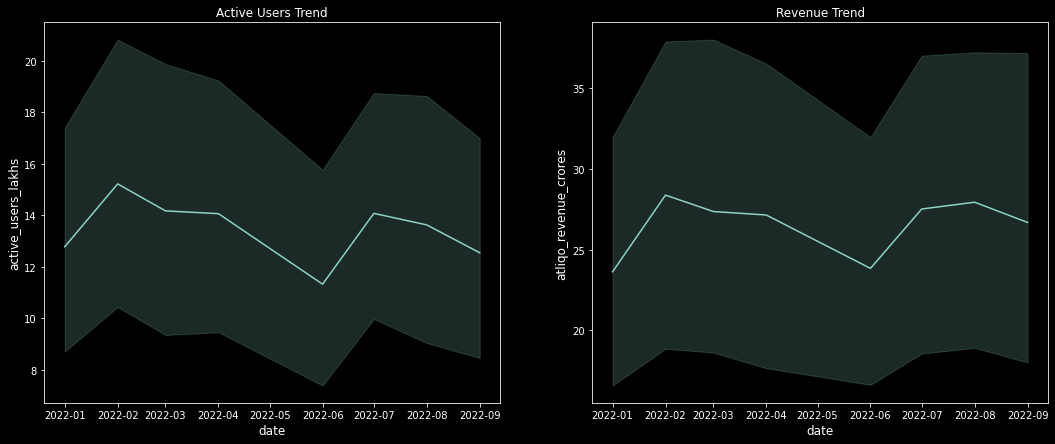

In [6]:
df_fact_atliqo_metrics["date"] = pd.to_datetime(df_fact_atliqo_metrics["date"], format="%d-%b-%y")
display(df_fact_atliqo_metrics)

fig, ax = plt.subplots(nrows=1, ncols=2)
sns.lineplot(x="date", y="active_users_lakhs", ax=ax[0], data=df_fact_atliqo_metrics).set_title("Active Users Trend")
sns.lineplot(x="date", y="atliqo_revenue_crores", ax=ax[1], data=df_fact_atliqo_metrics).set_title("Revenue Trend")
plt.show()

# Market Share

,date,city_code,tmv_city_crores,company,ms_pct
0,2022-01-01,400001,286.29,Atliqo,21.20
1,2022-01-01,110001,241.59,Atliqo,17.68
2,2022-01-01,700001,222.19,Atliqo,16.61
3,2022-01-01,560001,195.41,Atliqo,19.14
4,2022-01-01,600001,166.78,Atliqo,18.47
...,...,...,...,...,...
595,2022-09-01,800008,68.74,Others,5.87
596,2022-09-01,641001,60.90,Others,7.22
597,2022-09-01,160017,44.33,Others,7.35
598,2022-09-01,122001,34.48,Others,7.30


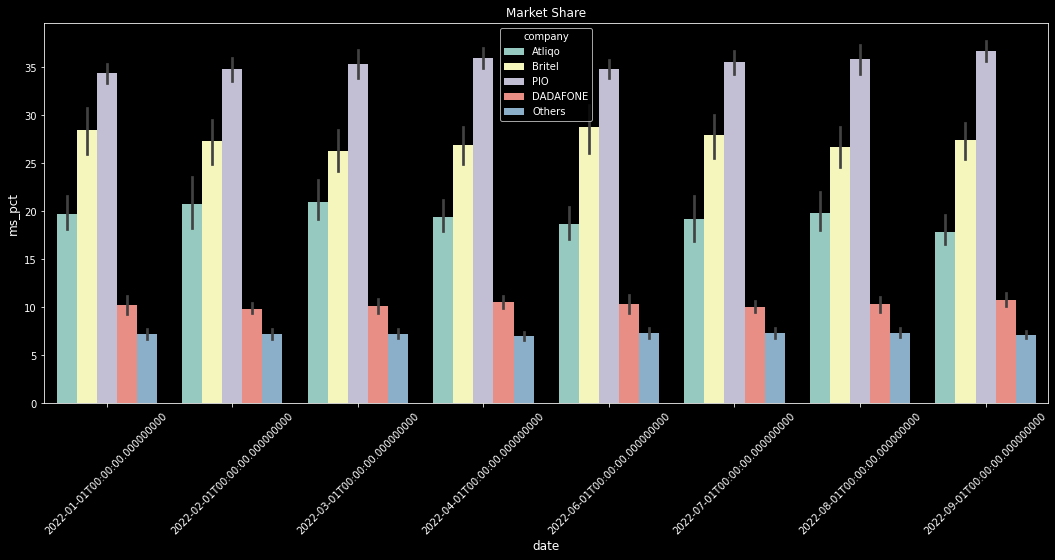

In [7]:
df_fact_market_share["date"] = pd.to_datetime(df_fact_market_share["date"], format="%d-%b-%y")
display(df_fact_market_share)

sns.barplot(x="date", y="ms_pct", hue="company", data=df_fact_market_share).set_title("Market Share")
plt.xticks(rotation=45)
plt.show()

# Plan Description (https://www.91mobiles.com/recharge-plans/airtel-prepaid-4g-data)

In [8]:
for desc in df_dim_plan["plan_description"]:
    print(desc)

df_dim_plan["data_size"] = pd.DataFrame({"data_size": [2, 1.5, 1, 0.5, 0.2, 15, 25, 1, 0.3, 6, 3, 1.8, 0.75]})
df_dim_plan["valid_period"] = pd.DataFrame({"valid_period": [180, 56, 28, 20, 28, 28, 30, 1, 28, 3, 80, 55, 28]})
display(df_dim_plan)

Smart Recharge Pack (2 GB / Day Combo For 3 months)
Super Saviour Pack (1.5 GB / Day Combo For 56 days)
Elite saver Pack (1 GB/ Day) Valid: 28 Days
Mini Data Saver Pack (500 MB/ Day) Valid: 20 Days
Rs. 99 Full Talktime Combo Pack
Xstream Mobile Data Pack: 15GB Data | 28 days
25 GB Combo 3G / 4G Data Pack
Daily Saviour (1 GB / Day) validity: 1 Day
Combo TopUp: 14.95 Talktime and 300 MB data
Big Combo Pack (6 GB / Day) validity: 3 Days
Ultra Fast Mega Pack (3GB / Day Combo For 80 days)
Ultra Duo Data Pack (1.8GB / Day Combo For 55 days )
Mini Ultra Saver Pack (750 MB/Day for 28 Days)


,plan,plan_description,data_size,valid_period
0,p1,Smart Recharge Pack (2 GB / Day Combo For 3 mo...,2.00,180
1,p2,Super Saviour Pack (1.5 GB / Day Combo For 56 ...,1.50,56
2,p3,Elite saver Pack (1 GB/ Day) Valid: 28 Days,1.00,28
3,p4,Mini Data Saver Pack (500 MB/ Day) Valid: 20 Days,0.50,20
4,p5,Rs. 99 Full Talktime Combo Pack,0.20,28
5,p6,Xstream Mobile Data Pack: 15GB Data | 28 days,15.00,28
6,p7,25 GB Combo 3G / 4G Data Pack,25.00,30
7,p8,Daily Saviour (1 GB / Day) validity: 1 Day,1.00,1
8,p9,Combo TopUp: 14.95 Talktime and 300 MB data,0.30,28
9,p10,Big Combo Pack (6 GB / Day) validity: 3 Days,6.00,3


# Merging Tables and Data Wrangling

In [9]:
df = pd.merge(
    left=df_fact_plan_revenue,
    right=df_dim_cities,
    left_on=["city_code"],
    right_on=["city_code"],
    how="left",
)
df = pd.merge(
    left=df,
    right=df_dim_plan,
    left_on=["plans"],
    right_on=["plan"],
    how="left",
)
df = pd.merge(
    left=df,
    right=df_dim_date,
    left_on=["date"],
    right_on=["date"],
    how="left",
)
df = df[["city_name", "time_period", "data_size", "valid_period", "before/after_5g", "plan_revenue_crores"]]
display(df)

,city_name,time_period,data_size,valid_period,before/after_5g,plan_revenue_crores
0,Mumbai,1,2.00,180,Before 5G,6.26
1,Delhi,1,2.00,180,Before 5G,4.58
2,Kolkata,1,2.00,180,Before 5G,4.29
3,Bangalore,1,2.00,180,Before 5G,4.26
4,Chennai,1,2.00,180,Before 5G,3.60
...,...,...,...,...,...,...
1195,Gurgaon,4,1.80,55,After 5G,0.43
1196,Gurgaon,4,0.75,28,After 5G,0.09
1197,Raipur,4,3.00,80,After 5G,0.48
1198,Raipur,4,1.80,55,After 5G,0.29


# Defining Parameters

In [10]:
RANDOM_STATE = 11
SEARCH = ["hyperband", "random", "bayesian"][0]
EPOCHS = 500
MAX_TRIALS = 20
DUPLICATES = 0
SCALER = 1
CLASSIFICATION = 0

print("-------------------------------------------------------")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Duplicates Percentage: {df.duplicated().sum() / df.shape[0] * 100:.2f}%")
if DUPLICATES:
    print(f"Duplicates have been kept {df.shape}.")
else:
    df.drop_duplicates(inplace=True)
    print(f"Duplicates have been removed {df.shape}.")
display(df.sample(3))
y_label = "plan_revenue_crores"

-------------------------------------------------------
Current Shape: (1200, 6).
-------------------------------------------------------
Duplicates Percentage: 0.00%
Duplicates have been removed (1200, 6).


,city_name,time_period,data_size,valid_period,before/after_5g,plan_revenue_crores
954,Jaipur,3,1.00,1,Before 5G,0.37
82,Ahmedabad,2,2.00,180,After 5G,2.86
382,Ahmedabad,2,0.50,20,Before 5G,1.08


# Counting Target Values

In [11]:
df.dropna(subset=[y_label], axis=0, inplace=True)
print("-------------------------------------------------------")
print(f"Dropping null target values.")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"y Value Counts:\n")
display(df[y_label].value_counts().to_frame().rename({y_label: "Count"}, axis=1))

-------------------------------------------------------
Dropping null target values.
Current Shape: (1200, 6).
-------------------------------------------------------
y Value Counts:



,Count
0.34,15
0.26,12
0.41,12
0.19,12
0.44,11
...,...
0.98,1
4.32,1
4.17,1
4.58,1


# Correlation Matrix

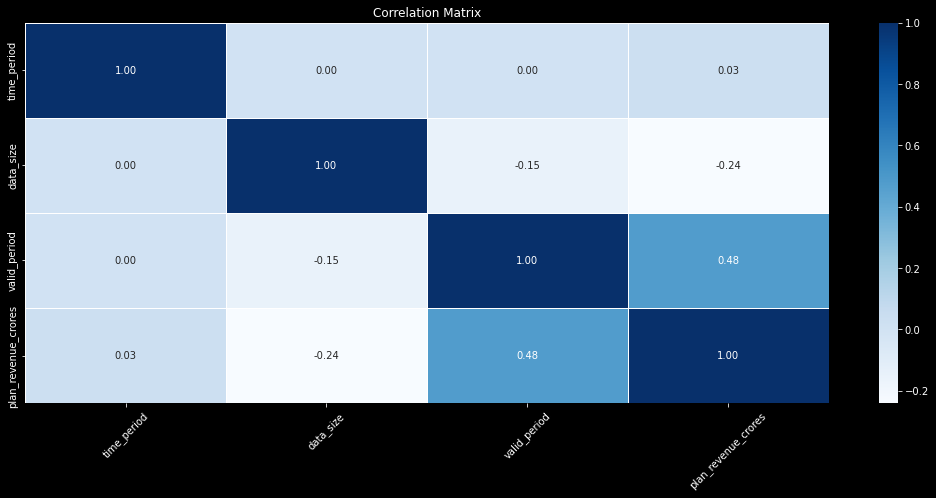

In [12]:
sns.heatmap(df.corr(), cmap="Blues", fmt=".2f", annot=True, linewidths=1)
plt.title("Correlation Matrix")
plt.xticks(rotation=45)
plt.show()

# Eliminating Multicollinearity between Features

In [13]:
def correlation(X, threshold):
    col_corr = set()
    df_corr = X.corr().abs()
    for i, _ in enumerate(df_corr.columns):
        for j in range(i):
            if (df_corr.iloc[i, j] >= threshold) and (
                df_corr.columns[j] not in col_corr
            ):
                col_corr.add(df_corr.columns[i])
    return col_corr

col_drop = correlation(df.drop(y_label, axis=1), 0.85)
df.drop(col_drop, inplace=True, axis=1)
print("-------------------------------------------------------")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Highly correlated cols have been removed: {len(col_drop)}.")
print(f"Highly correlated cols: {col_drop}.")

-------------------------------------------------------
Current Shape: (1200, 6).
-------------------------------------------------------
Highly correlated cols have been removed: 0.
Highly correlated cols: set().


# Checking NULL Values

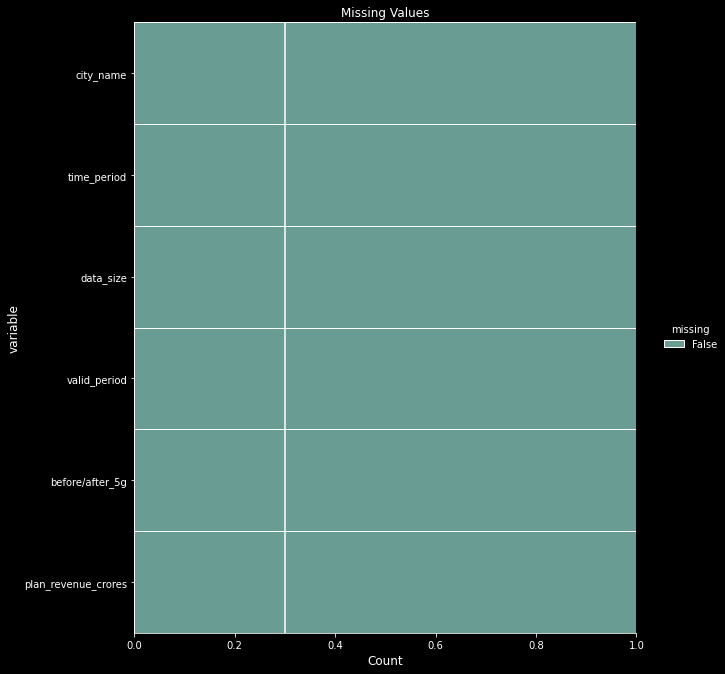

In [14]:
sns.displot(
    data=df.isnull().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    height=9.25,
)
plt.axvline(0.3, color="white")
plt.title("Missing Values")
plt.show()

# Feature Description

In [15]:
col_cat_oe = []
preprocessor_cat_oe = make_pipeline(
    (SimpleImputer(strategy="most_frequent")),
    (OrdinalEncoder(categories=[["", ""]])),
)
col_cat = [col for col in df.columns if np.issubsctype(df[col].dtype, np.object0) and col != y_label]
col_num = [col for col in df.columns if np.issubsctype(df[col].dtype, np.number) and col != y_label]
col_cat_ohe = [col for col in col_cat if col not in col_cat_oe]
col_num_disc = [col for col in col_num if df[col].nunique() <= 8]
col_num_cont = [col for col in col_num if col not in col_num_disc]

df_info = pd.DataFrame(
    {
        "column": [col for col in df.columns],
        "dtype": [f"{df[col].dtype}" for col in df.columns],
        "na": [f"{df[col].isna().sum()}" for col in df.columns],
        "na %": [f"{round(df[col].isna().sum() / df[col].shape[0] * 100)}%" for col in df.columns],
        "outliers": [f"{((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()}" if col in col_num else "n/a" for col in df.columns],
        "outliers %": [f"{round((((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()) / df[col].shape[0] * 100)}%" if col in col_num else "n/a" for col in df.columns],
        "kurtosis": [f"{df[col].kurtosis(axis=0, skipna=True):.2f}" if col in col_num else "n/a" for col in df.columns],
        "skewness": [f"{df[col].skew(axis=0, skipna=True):.2f}" if col in col_num else "n/a" for col in df.columns],
        "corr": [f"{round(df[col].corr(other=df[y_label]) * 100)}%" if col in col_num else "n/a" for col in df.columns],
        "nunique": [f"{df[col].nunique()}" for col in df.columns],
        "unique": [sorted(df[col].unique()) if col in col_num else df[col].unique() for col in df.columns],
    }
).sort_values(by="dtype", ascending=False)
display(df_info)
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"total na %: {df.isnull().sum().sum() / np.product(df.shape) * 100:.2f}%")
print("-------------------------------------------------------")
print(f"col_cat_oe ({len(col_cat_oe)}): {col_cat_oe}")
print(f"col_cat_ohe ({len(col_cat_ohe)}): {col_cat_ohe}")
print(f"col_num_disc ({len(col_num_disc)}): {col_num_disc}")
print(f"col_num_cont ({len(col_num_cont)}): {col_num_cont}")
print("-------------------------------------------------------")
print(f"total cols for preprocessor: {len(col_cat_oe) + len(col_cat_ohe) + len(col_num_disc) + len(col_num_cont)}")

,column,dtype,na,na %,outliers,outliers %,kurtosis,skewness,corr,nunique,unique
0,city_name,object,0,0%,n/a,n/a,n/a,n/a,n/a,15,"[Mumbai, Delhi, Kolkata, Bangalore, Chennai, H..."
4,before/after_5g,object,0,0%,n/a,n/a,n/a,n/a,n/a,2,"[Before 5G, After 5G]"
1,time_period,int64,0,0%,0,0%,-1.36,0.00,3%,4,"[1, 2, 3, 4]"
3,valid_period,int64,0,0%,120,10%,3.17,2.06,48%,9,"[1, 3, 20, 28, 30, 55, 56, 80, 180]"
2,data_size,float64,0,0%,240,20%,1.40,1.70,-24%,12,"[0.2, 0.3, 0.5, 0.75, 1.0, 1.5, 1.8, 2.0, 3.0,..."
5,plan_revenue_crores,float64,0,0%,n/a,n/a,n/a,n/a,n/a,419,"[6.26, 4.58, 4.29, 4.26, 3.6, 3.26, 2.27, 2.68..."


Current Shape: (1200, 6).
-------------------------------------------------------
total na %: 0.00%
-------------------------------------------------------
col_cat_oe (0): []
col_cat_ohe (2): ['city_name', 'before/after_5g']
col_num_disc (1): ['time_period']
col_num_cont (2): ['data_size', 'valid_period']
-------------------------------------------------------
total cols for preprocessor: 5


# Frequency Encoding (http://proceedings.mlr.press/v7/niculescu09/niculescu09.pdf)

In [16]:
for col in col_cat_ohe:
    sr_temp = df.groupby(col)[y_label].count() / df.shape[0]
    df_temp = sr_temp[sr_temp > 0.01].index
    df[col] = np.where(df[col].isin(df_temp), df[col], "-")

# Count Encoding (http://proceedings.mlr.press/v7/niculescu09/niculescu09.pdf)

In [17]:
MAX_COLS = 20
for col in col_cat_ohe:
    indice = df[col].value_counts()[:MAX_COLS].index
    df_temp = df[col].map(lambda value: value if value in indice else "-")
    df[col] = df_temp
    print(df_temp.value_counts())
    print(f"unique values: {df_temp.nunique()}")
    print("-------------------------------------------------------")
try:
    display(df.describe(exclude="number").T.style.background_gradient(cmap="Blues"))
except Exception:
    pass

Mumbai        80
Delhi         80
Kolkata       80
Bangalore     80
Chennai       80
Hyderabad     80
Pune          80
Ahmedabad     80
Jaipur        80
Lucknow       80
Patna         80
Coimbatore    80
Chandigarh    80
Gurgaon       80
Raipur        80
Name: city_name, dtype: int64
unique values: 15
-------------------------------------------------------
Before 5G    600
After 5G     600
Name: before/after_5g, dtype: int64
unique values: 2
-------------------------------------------------------


,count,unique,top,freq
city_name,1200,15,Mumbai,80
before/after_5g,1200,2,Before 5G,600


# Countplot for Categorical Feature(s)

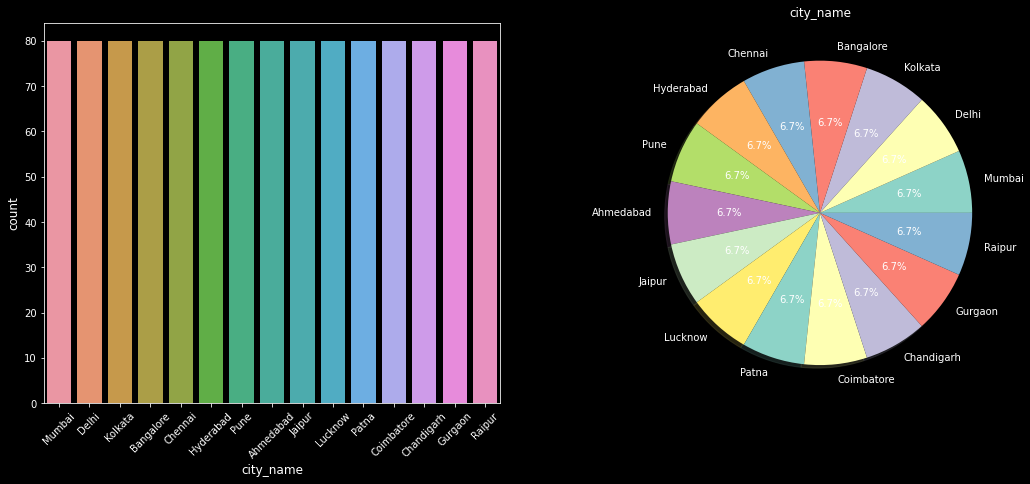

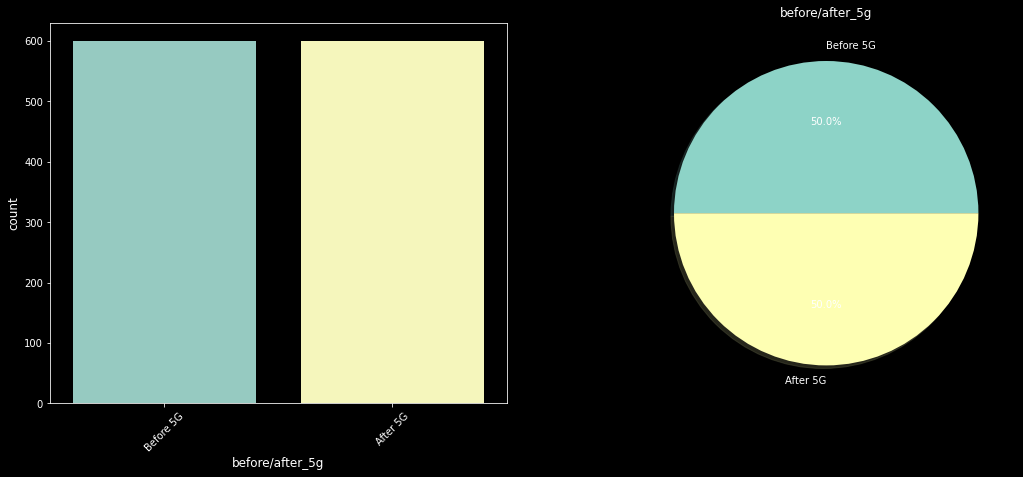

In [18]:
for col in col_cat:
    fig, ax = plt.subplots(nrows=1, ncols=2)
    sns.countplot(x=df[col], ax=ax[0], hue=df[y_label] if CLASSIFICATION else None).set_xlabel(f"{col}")
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
    ax[1].pie(x=df[col].value_counts(), autopct="%.1f%%", shadow=True, labels=df[col].value_counts().index)
    ax[1].set_title(col)
plt.show()

# Distplot for Discrete Numeric Feature(s)

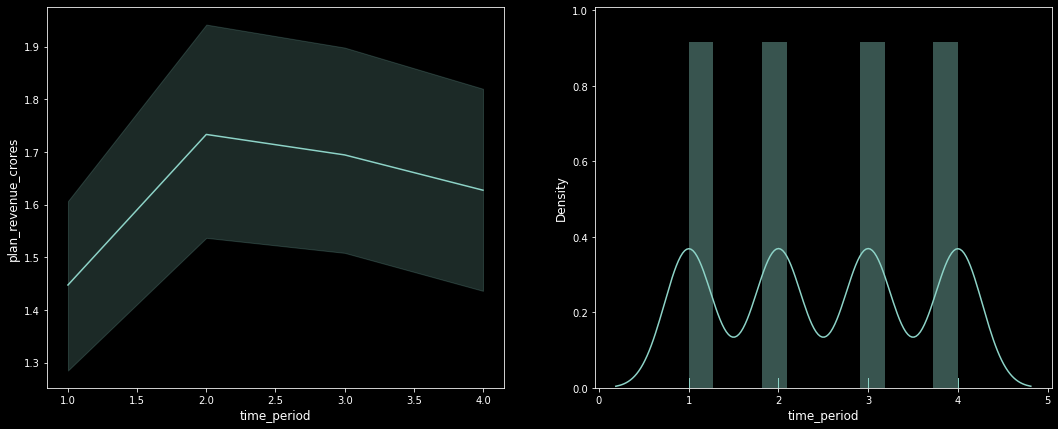

In [19]:
for col in col_num_disc + ([y_label] if CLASSIFICATION else []):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    sns.lineplot(x=df[col], y=df[y_label], ax=ax[0]).set_xlabel(f"{col}")
    sns.distplot(x=df[col], ax=ax[1], rug=True).set_xlabel(f"{col}")
plt.show()

# Detecting Outliers

In [20]:
transformation_table = {
    "log": [],
    "log1p": [],
    "reciprocal": [],
    "sqrt": [],
    "exp": [],
    "boxcox": [],
    "boxcox1": [],
    "cap": [],
    "drop": [],
    "keep": df.columns.tolist(),
}
for transform, cols in transformation_table.items():
    if cols:
        col_outlier = [col for col in col_num_cont + ([] if CLASSIFICATION else [y_label]) if col in cols]
        q1, q3 = df[col_outlier].quantile(0.25), df[col_outlier].quantile(0.75)
        iqr = q3 - q1
        lower_range, upper_range = q1 - (1.5 * iqr), q3 + (1.5 * iqr)
        condition = ~((df[col_outlier] < lower_range) | (df[col_outlier] > upper_range)).any(axis=1)
        print("-------------------------------------------------------")
        print(f"Performing {transform} transformation on cols {cols}.")
        print(f"Current Shape: {df.shape}.")
        print("-------------------------------------------------------")
        print(f"Scanning for outliers in {col_outlier}.")
        print(f"Outliers Percentage: {(df.shape[0] - df[condition].shape[0]) / df.shape[0] * 100:.2f}%")
        print("-------------------------------------------------------")
        print(f"upper_range:\n{upper_range}")
        print("-------------------------------------------------------")
        print(f"lower_range:\n{lower_range}")
        print("-------------------------------------------------------")
        if transform == "keep":
            print(f"Outliers have been kept {df.shape}.")
        elif transform == "cap":
            for col in col_outlier:
                df[col] = np.where(df[col] < lower_range[col], lower_range[col], df[col])
                df[col] = np.where(df[col] > upper_range[col], upper_range[col], df[col])
            print(f"Outliers have been capped {df.shape}.")
        elif transform == "drop":
            df = df[condition]
            print(f"Outliers have been removed {df.shape}.")
        elif transform == "log":
            for col in col_outlier:
                df[col] = np.log(df[col])
            print(f"Outliers have been log transformed {df.shape}.")
        elif transform == "log1p":
            for col in col_outlier:
                df[col] = np.log1p(df[col])
            print(f"Outliers have been log1p transformed {df.shape}.")
        elif transform == "reciprocal":
            for col in col_outlier:
                df[col] = (1 / df[col])
            print(f"Outliers have been reciprocal transformed {df.shape}.")
        elif transform == "sqrt":
            for col in col_outlier:
                df[col] = (df[col] ** 0.5)
            print(f"Outliers have been sqrt transformed {df.shape}.")
        elif transform == "exp":
            for col in col_outlier:
                df[col] = (df[col] ** (1/1.2))
            print(f"Outliers have been exp transformed {df.shape}.")
        elif transform == "boxcox":
            for col in col_outlier:
                df[col] = stat.boxcox(df[col])[0]
            print(f"Outliers have been boxcox transformed {df.shape}.")
        elif transform == "boxcox1":
            for col in col_outlier:
                df[col] = stat.boxcox(df[col] + 1)[0]
            print(f"Outliers have been boxcox1 transformed {df.shape}.")
        print("\n\n")

-------------------------------------------------------
Performing keep transformation on cols ['city_name', 'time_period', 'data_size', 'valid_period', 'before/after_5g', 'plan_revenue_crores'].
Current Shape: (1200, 6).
-------------------------------------------------------
Scanning for outliers in ['data_size', 'valid_period', 'plan_revenue_crores'].
Outliers Percentage: 32.25%
-------------------------------------------------------
upper_range:
data_size              8.34
valid_period          96.12
plan_revenue_crores    5.14
dtype: float64
-------------------------------------------------------
lower_range:
data_size              -3.91
valid_period          -12.88
plan_revenue_crores    -2.42
dtype: float64
-------------------------------------------------------
Outliers have been kept (1200, 6).





# Distplot, Boxplot and QQplot for Analysing Statistical Distribution of Each Feature

-------------------------------------------------------
data_size
Skew: 1.70
Kurtosis: 1.40


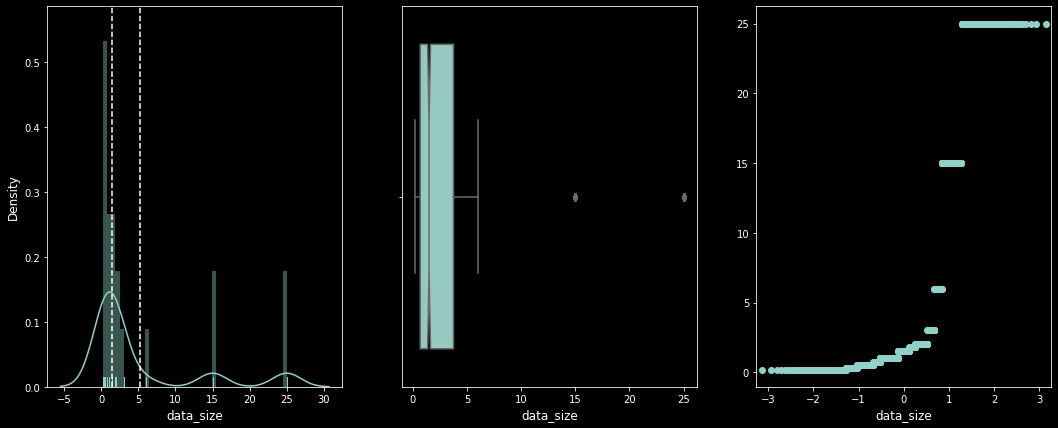

-------------------------------------------------------
valid_period
Skew: 2.06
Kurtosis: 3.17


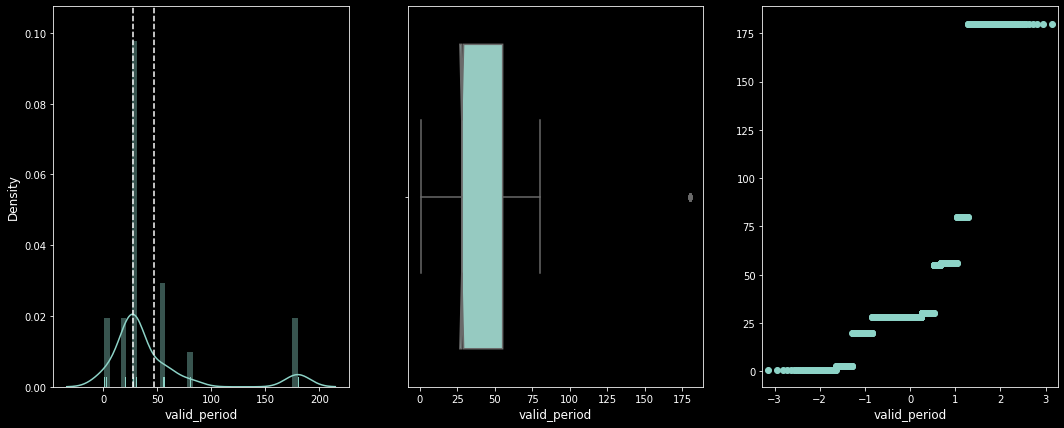

-------------------------------------------------------
plan_revenue_crores
Skew: 1.75
Kurtosis: 3.65


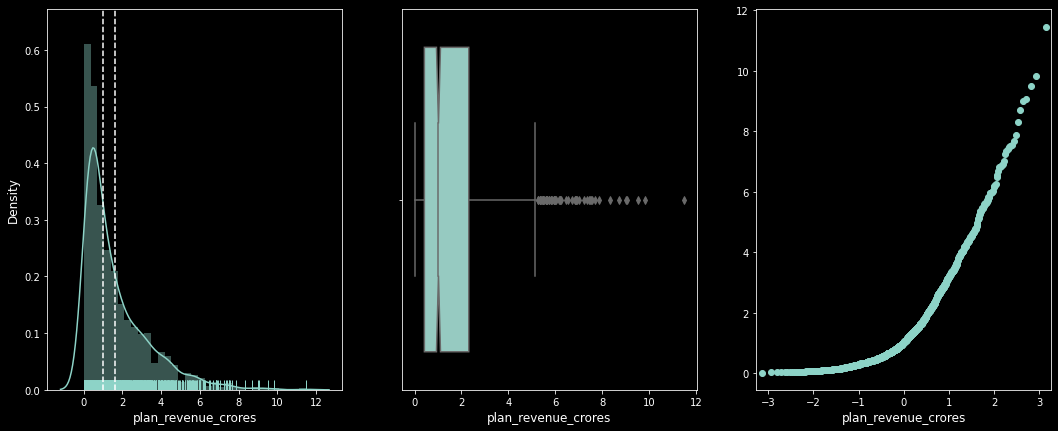

In [21]:
for col in col_num_cont + ([] if CLASSIFICATION else [y_label]):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    sns.distplot(x=df[col], ax=ax[0], rug=True).set_xlabel(f"{col}")
    sns.boxplot(x=df[col], ax=ax[1], notch=True).set_xlabel(f"{col}")
    sm.qqplot(data=df[col], ax=ax[2], xlabel=col, ylabel="")
    ax[0].axvline(x=df[col].mean(), linestyle="--")
    ax[0].axvline(x=df[col].median(), linestyle="--")
    print("-------------------------------------------------------")
    print(f"{col}\nSkew: {df[col].skew(axis=0, skipna=True):.2f}\nKurtosis: {df[col].kurtosis(axis=0, skipna=True):.2f}")
    plt.show()

# Statistical Analysis: Data Transformation to the Gaussian Distribution

-------------------------------------------------------
data_size Keep Transformation
Skew: 1.70
Kurtosis: 1.40
lambda: 0


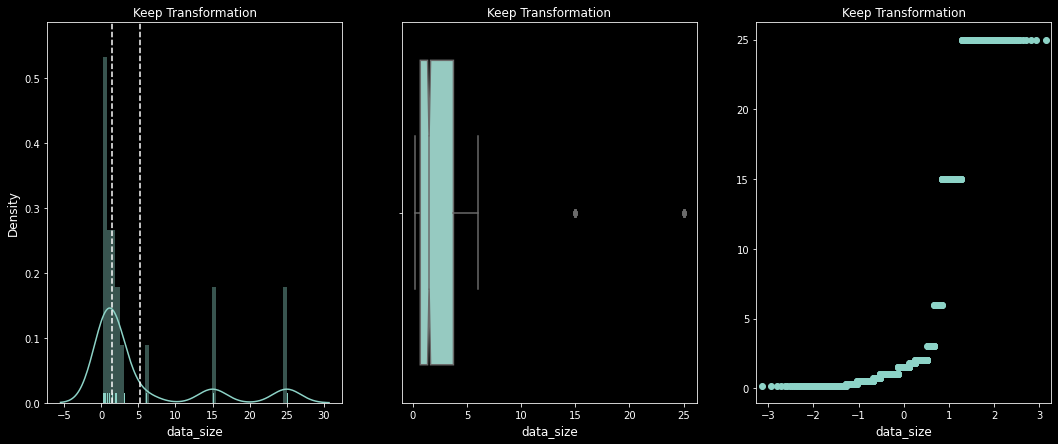

-------------------------------------------------------
data_size Log Transformation
Skew: 0.43
Kurtosis: -0.75
lambda: 0


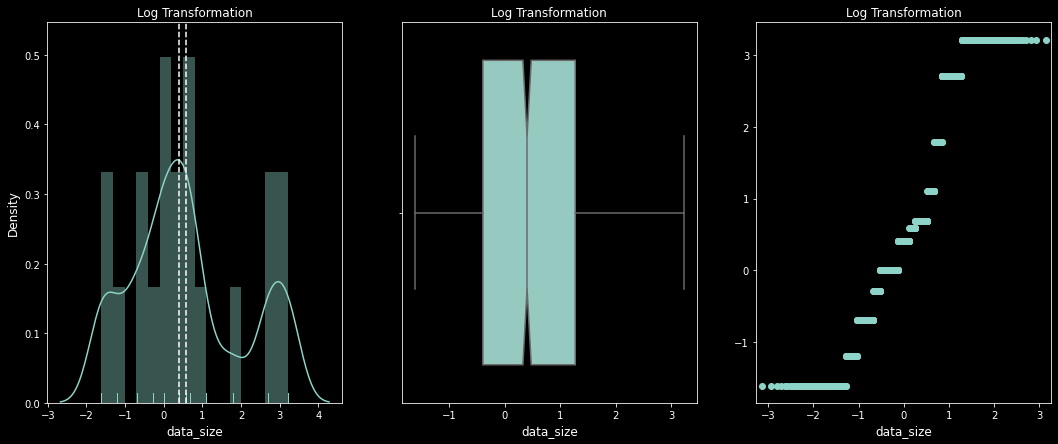

-------------------------------------------------------
data_size Log1P Transformation
Skew: 1.00
Kurtosis: -0.37
lambda: 0


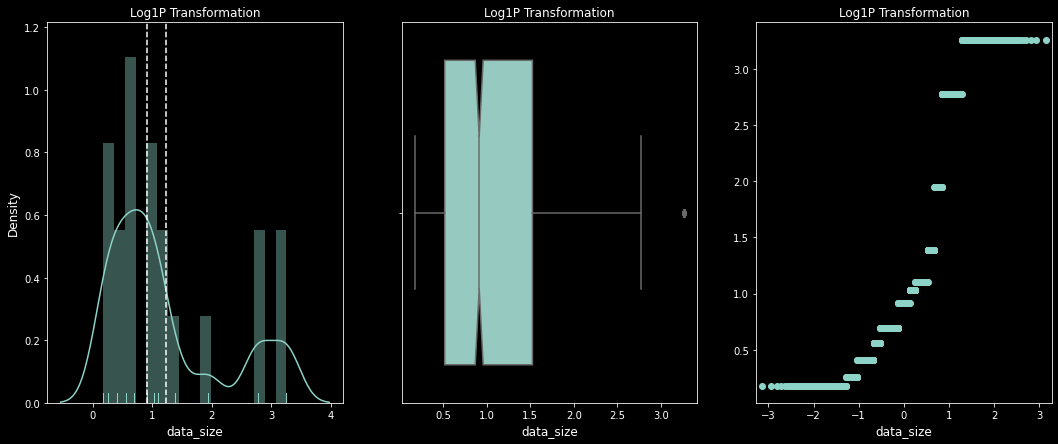

-------------------------------------------------------
data_size Reciprocal Transformation
Skew: 1.59
Kurtosis: 1.40
lambda: 0


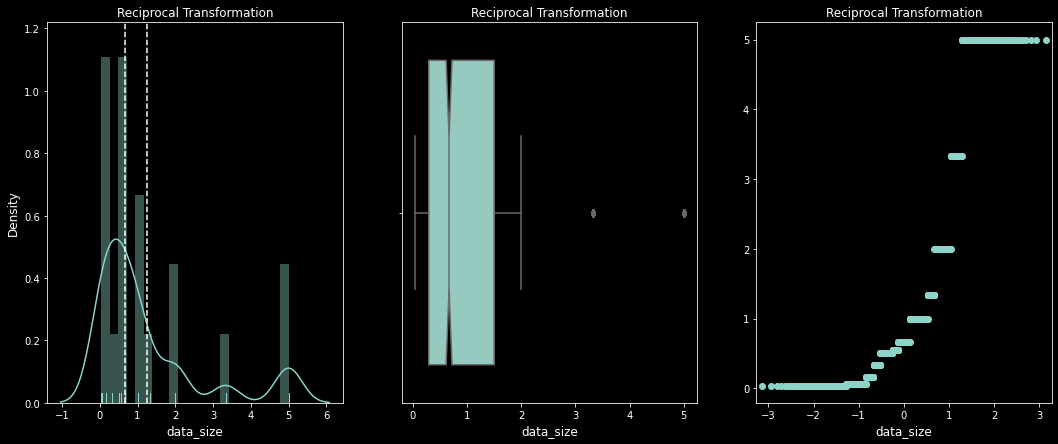

-------------------------------------------------------
data_size Sqrt Transformation
Skew: 1.29
Kurtosis: 0.23
lambda: 0


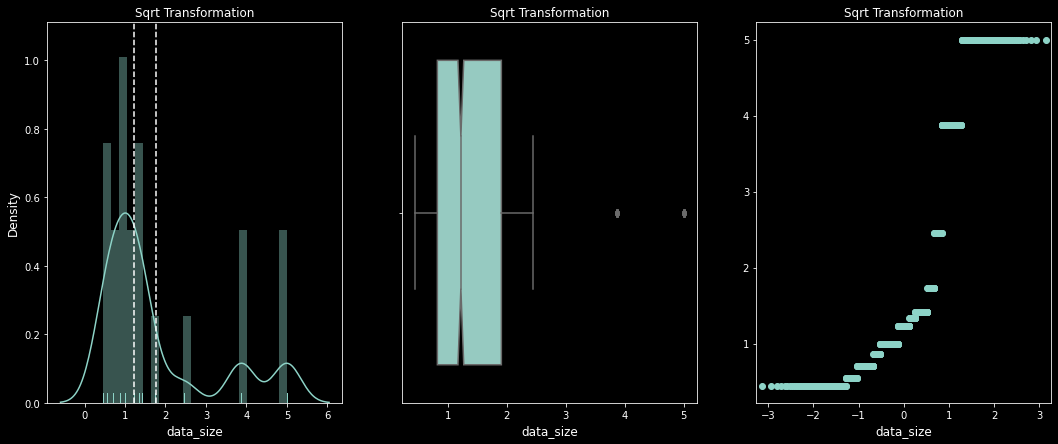

-------------------------------------------------------
data_size Exp Transformation
Skew: 1.59
Kurtosis: 1.02
lambda: 0


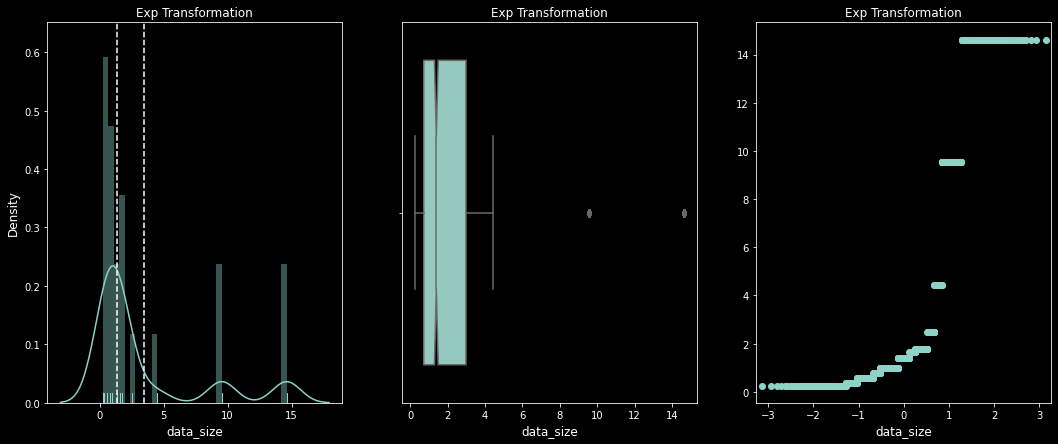

-------------------------------------------------------
data_size Boxcox Transformation
Skew: 0.06
Kurtosis: -0.80
lambda: -0.15236159025676418


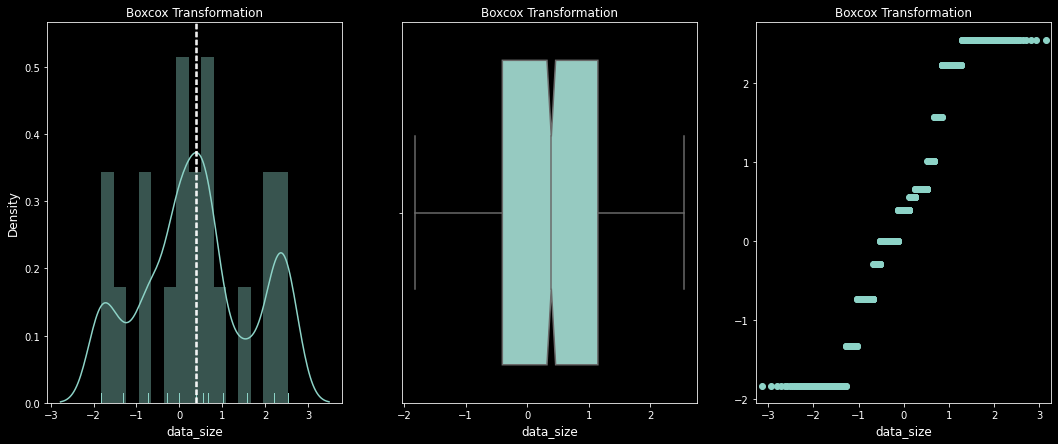

-------------------------------------------------------
data_size Boxcox1 Transformation
Skew: 0.30
Kurtosis: -1.02
lambda: -0.6747445728393661


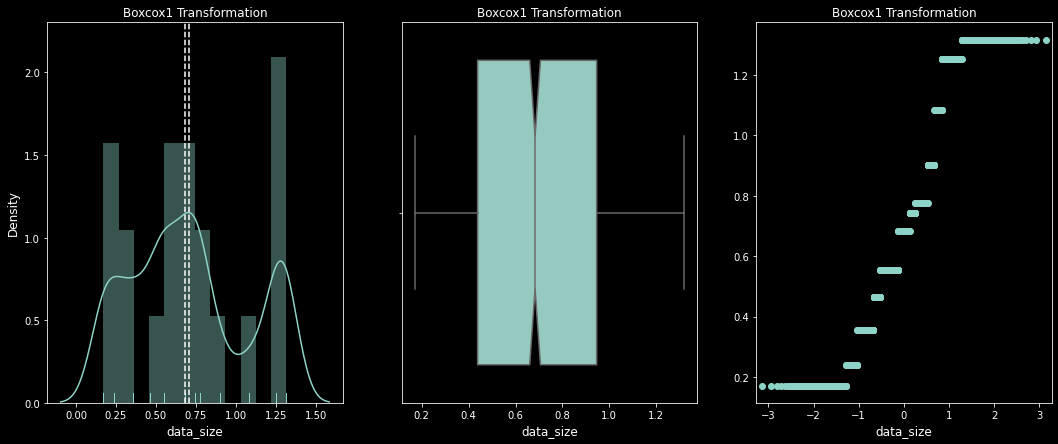

-------------------------------------------------------
valid_period Keep Transformation
Skew: 2.06
Kurtosis: 3.17
lambda: 0


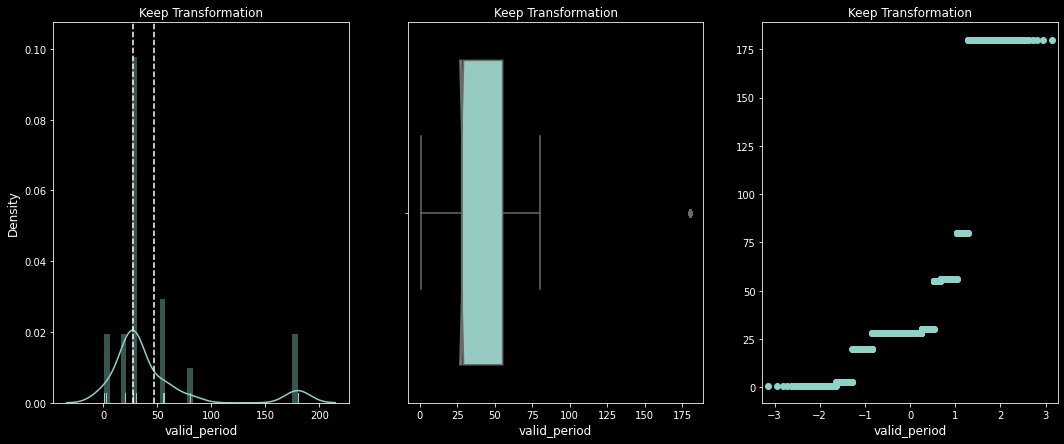

-------------------------------------------------------
valid_period Log Transformation
Skew: -1.24
Kurtosis: 2.42
lambda: 0


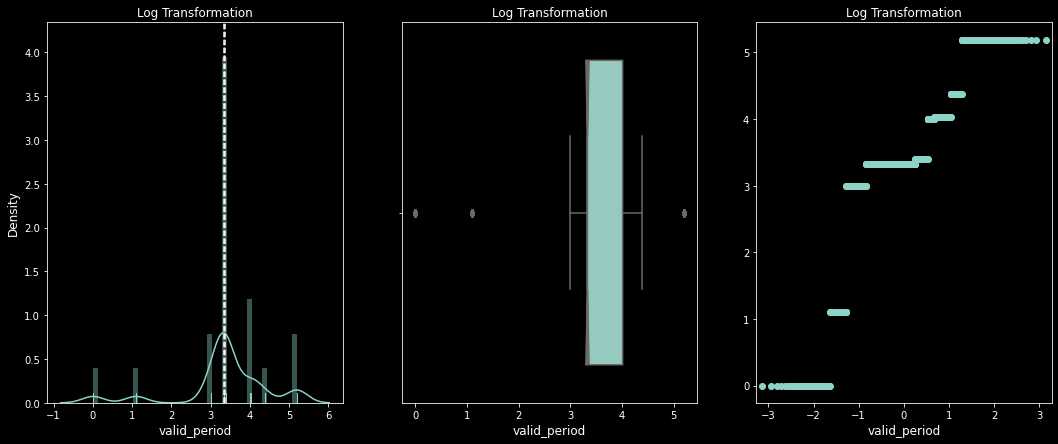

-------------------------------------------------------
valid_period Log1P Transformation
Skew: -0.85
Kurtosis: 1.65
lambda: 0


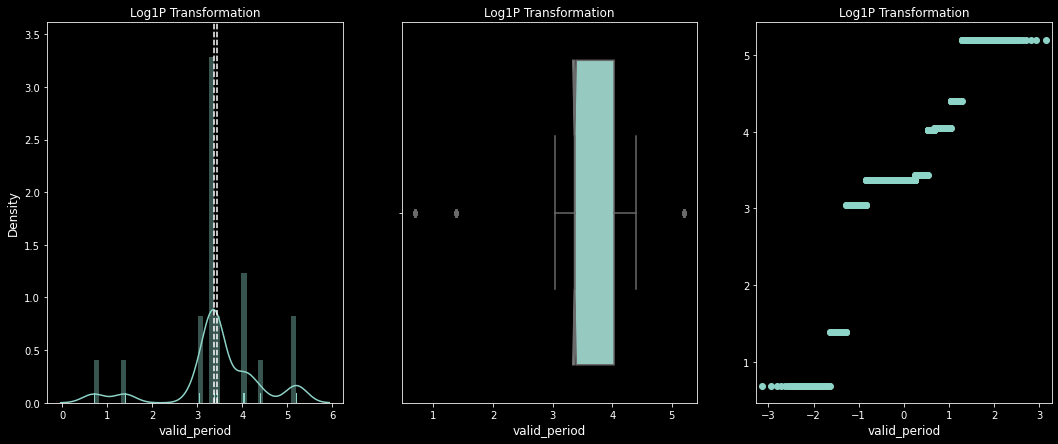

-------------------------------------------------------
valid_period Reciprocal Transformation
Skew: 3.61
Kurtosis: 11.93
lambda: 0


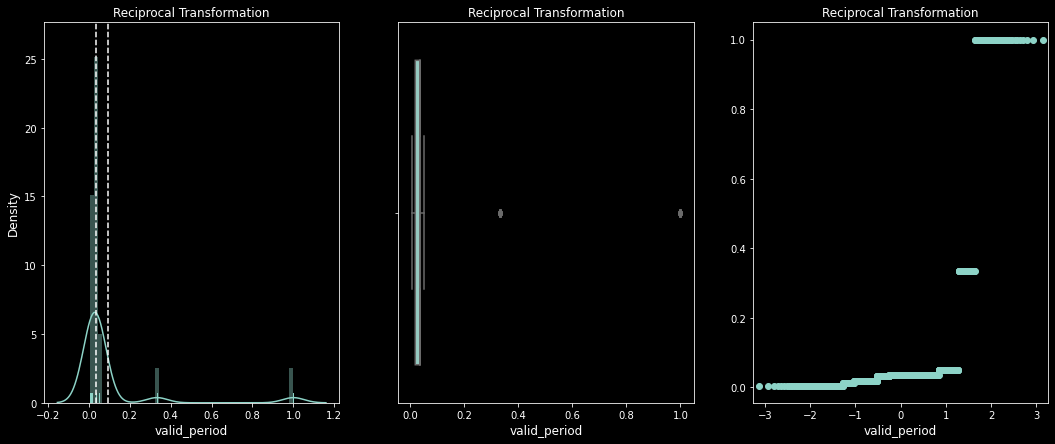

-------------------------------------------------------
valid_period Sqrt Transformation
Skew: 1.05
Kurtosis: 1.31
lambda: 0


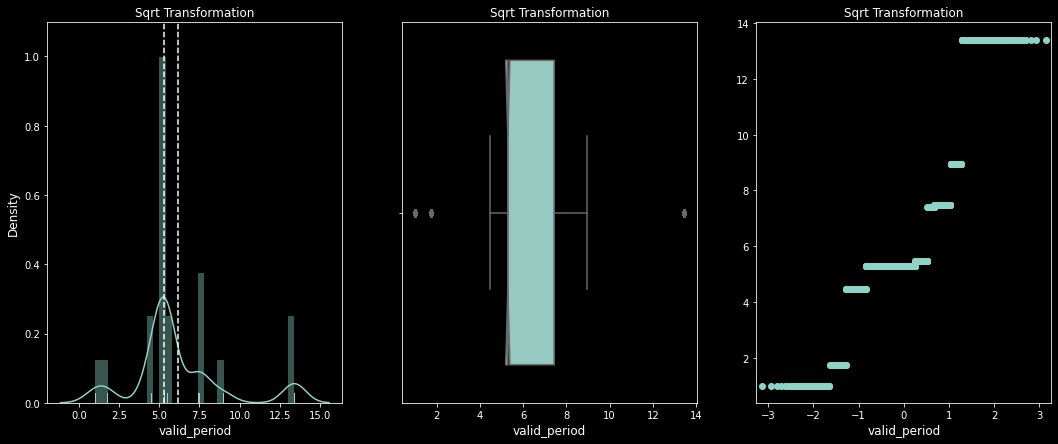

-------------------------------------------------------
valid_period Exp Transformation
Skew: 1.84
Kurtosis: 2.61
lambda: 0


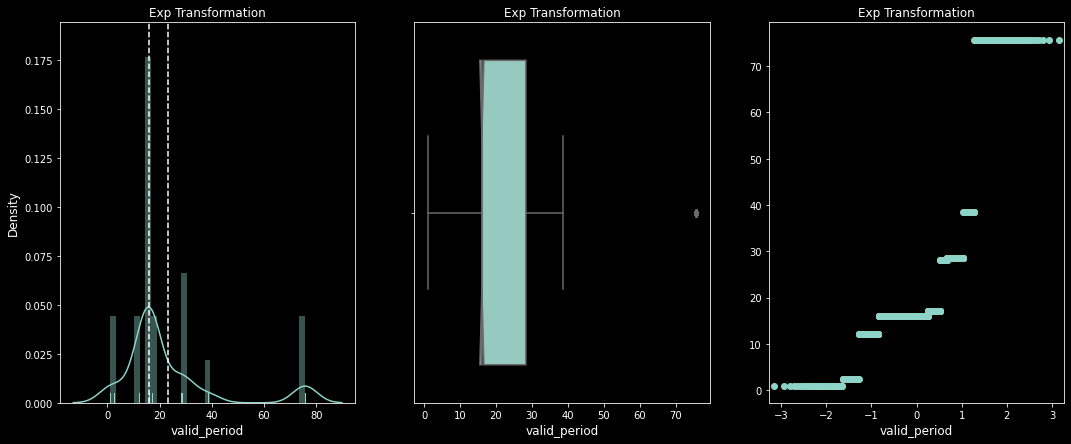

-------------------------------------------------------
valid_period Boxcox Transformation
Skew: 0.08
Kurtosis: 0.98
lambda: 0.2613605015797948


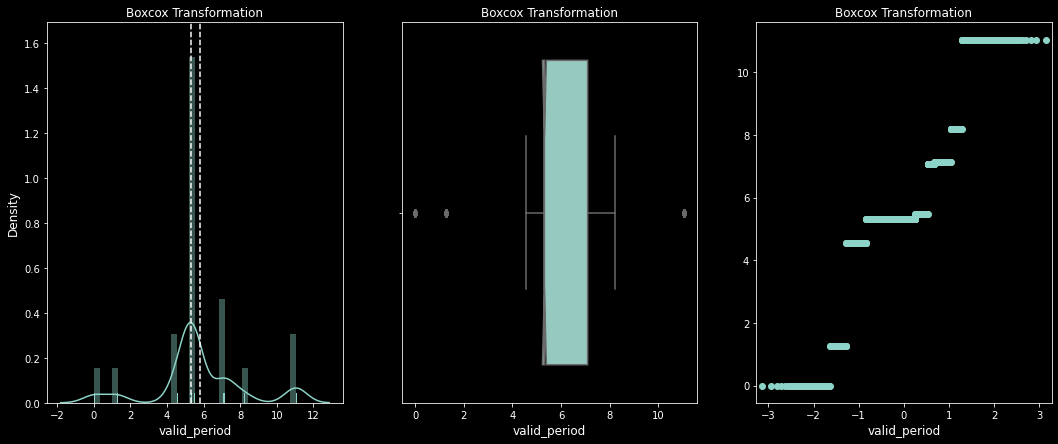

-------------------------------------------------------
valid_period Boxcox1 Transformation
Skew: 0.06
Kurtosis: 0.91
lambda: 0.205264841301333


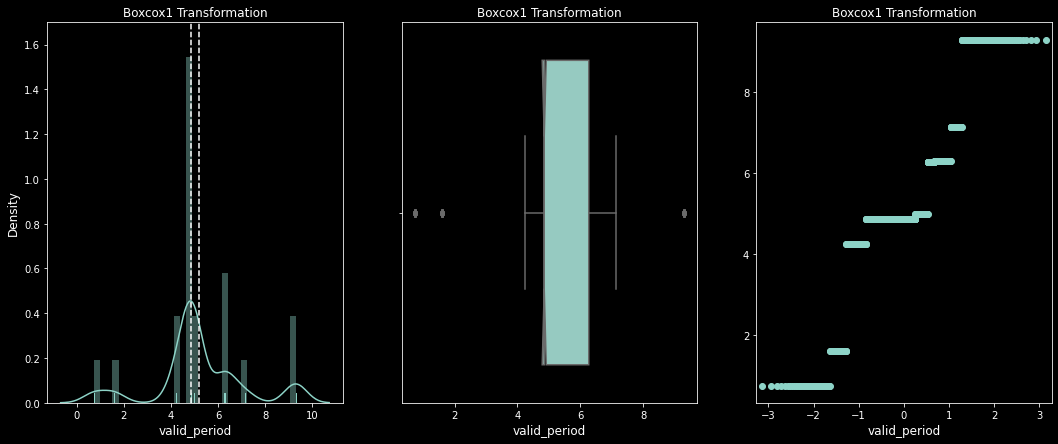

-------------------------------------------------------
plan_revenue_crores Keep Transformation
Skew: 1.75
Kurtosis: 3.65
lambda: 0


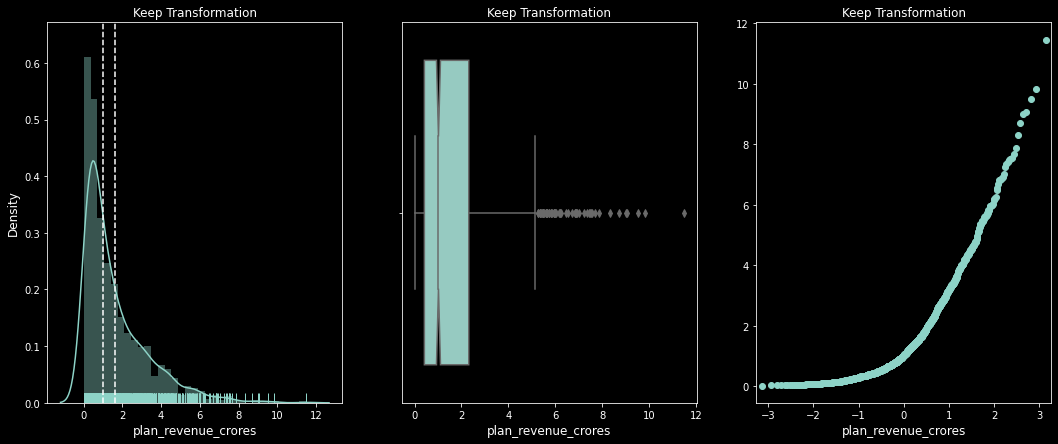

-------------------------------------------------------
plan_revenue_crores Log Transformation
Skew: -0.43
Kurtosis: -0.30
lambda: 0


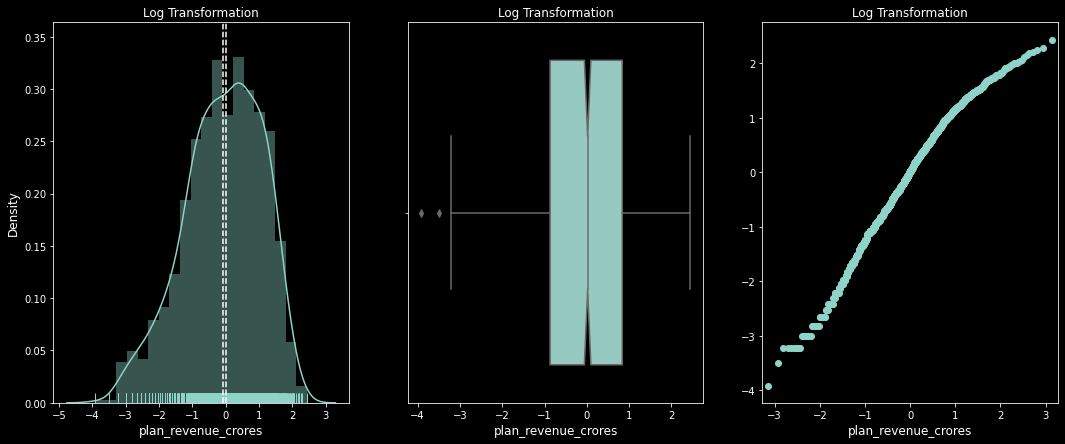

-------------------------------------------------------
plan_revenue_crores Log1P Transformation
Skew: 0.59
Kurtosis: -0.54
lambda: 0


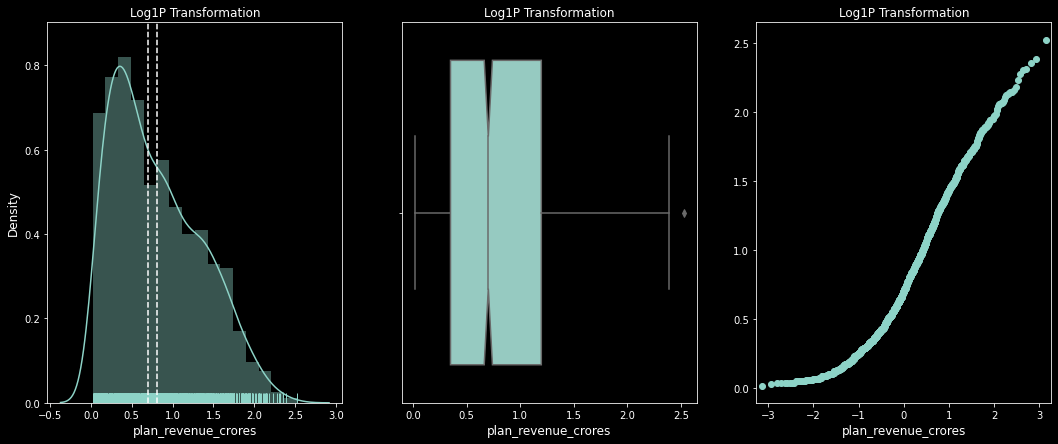

-------------------------------------------------------
plan_revenue_crores Reciprocal Transformation
Skew: 4.54
Kurtosis: 30.67
lambda: 0


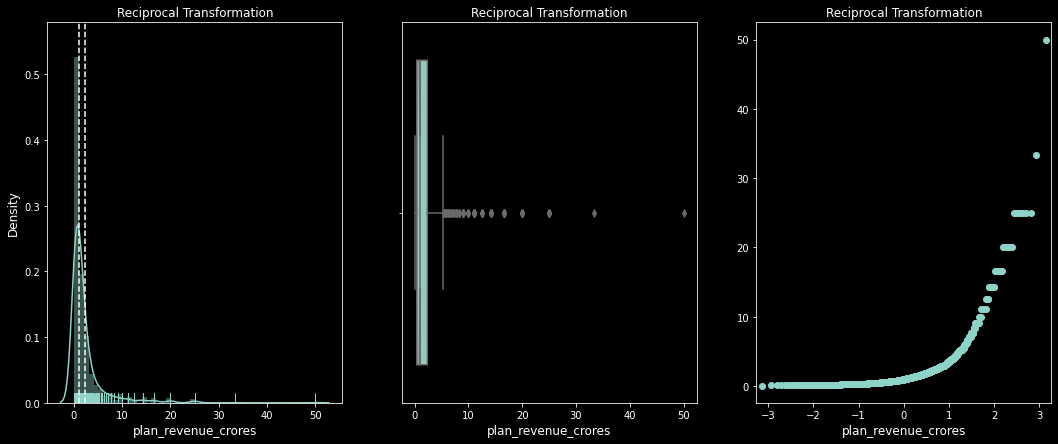

-------------------------------------------------------
plan_revenue_crores Sqrt Transformation
Skew: 0.71
Kurtosis: -0.05
lambda: 0


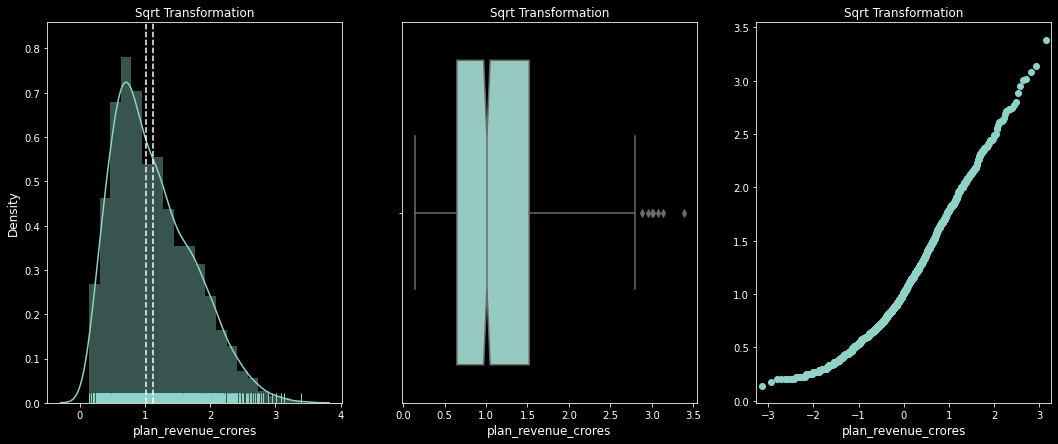

-------------------------------------------------------
plan_revenue_crores Exp Transformation
Skew: 1.40
Kurtosis: 2.00
lambda: 0


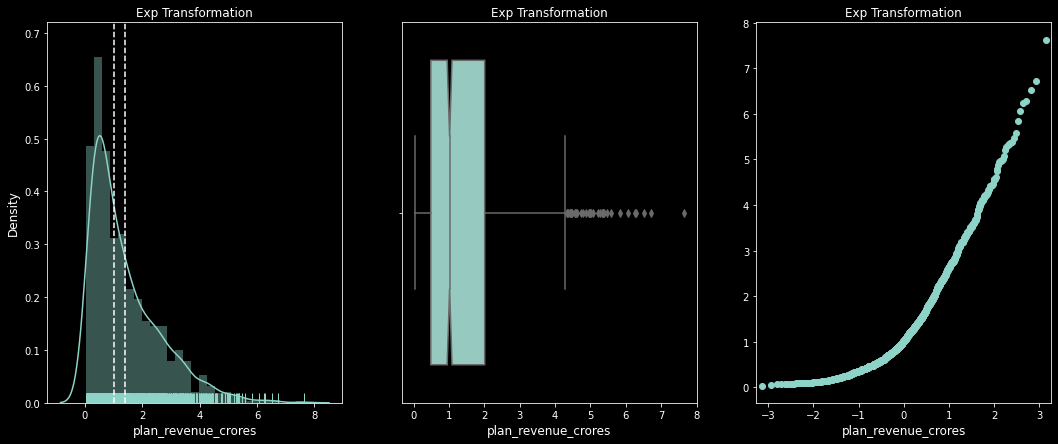

-------------------------------------------------------
plan_revenue_crores Boxcox Transformation
Skew: -0.04
Kurtosis: -0.64
lambda: 0.15785648372842692


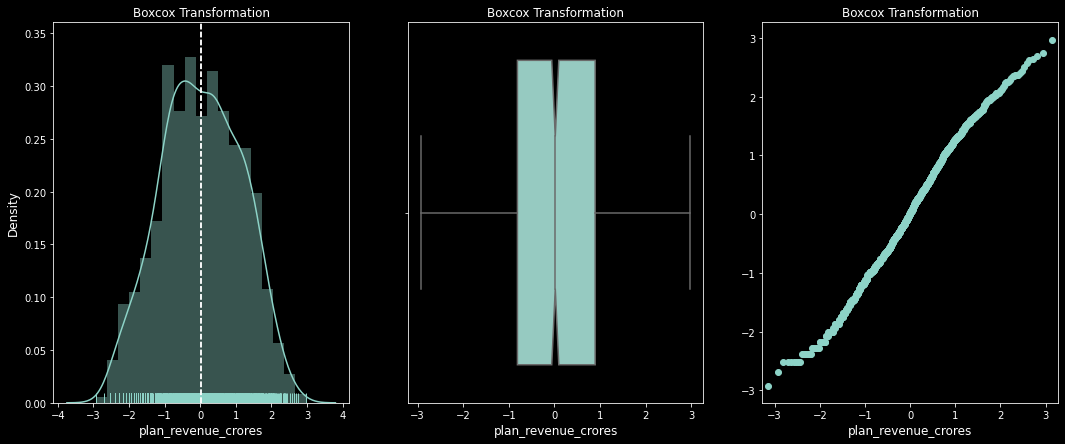

-------------------------------------------------------
plan_revenue_crores Boxcox1 Transformation
Skew: 0.12
Kurtosis: -1.08
lambda: -0.5901539135500311


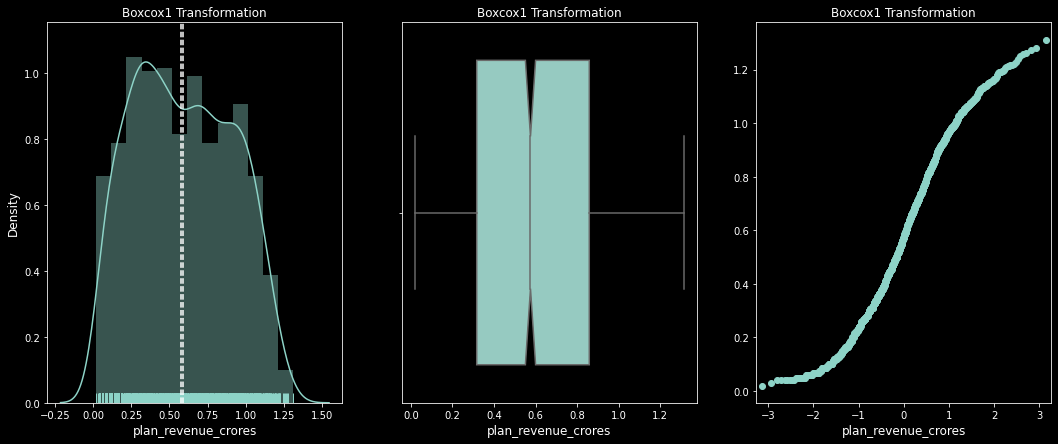

In [22]:
for col in col_num_cont + ([] if CLASSIFICATION else [y_label]):
    for trans in ["keep", "log", "log1p", "reciprocal", "sqrt", "exp", "boxcox", "boxcox1"]:
        lamb = 0
        try:
            fig, ax = plt.subplots(nrows=1, ncols=3)
            if trans == "keep":
                x = df[col]
            elif trans == "log":
                x = np.log(df[col])
            elif trans == "log1p":
                x = np.log1p(df[col])
            elif trans == "reciprocal":
                x=(1 / df[col])
            elif trans == "sqrt":
                x=(df[col] ** 0.5)
            elif trans == "exp":
                x=(df[col] ** (1/1.2))
            elif trans == "boxcox":
                val, lamb = stat.boxcox(df[col])
                x=pd.Series(val, name=col)
            else:
                val, lamb = stat.boxcox(df[col] + 1)
                x=pd.Series(val, name=col)
            sns.distplot(x=x, ax=ax[0], rug=True).set_xlabel(f"{col}")
            sns.boxplot(x=x, ax=ax[1], notch=True).set_xlabel(f"{col}")
            sm.qqplot(data=x, ax=ax[2], xlabel=col, ylabel="")
            ax[0].axvline(x=x.mean(), linestyle="--")
            ax[0].axvline(x=x.median(), linestyle="--")
        except Exception:
            pass
        finally:
            for i in range(3):
                ax[i].set_title(f"{trans.title()} Transformation")
            print("-------------------------------------------------------")
            print(f"{col} {trans.title()} Transformation\nSkew: {x.skew(axis=0, skipna=True):.2f}\nKurtosis: {x.kurtosis(axis=0, skipna=True):.2f}\nlambda: {lamb}")
            plt.show()

# Standard Distribution and Interquantile Range

In [23]:
display(df.describe().T.style.background_gradient(cmap="Blues").format("{:.2f}"))
display(df.quantile([0.01, 0.99]).T.style.background_gradient(cmap="Blues").format("{:.2f}"))

,count,mean,std,min,25%,50%,75%,max
time_period,1200.00,2.50,1.12,1.00,1.75,2.50,3.25,4.00
data_size,1200.00,5.16,7.85,0.20,0.69,1.50,3.75,25.00
valid_period,1200.00,46.75,47.80,1.00,28.00,28.00,55.25,180.00
plan_revenue_crores,1200.00,1.63,1.66,0.02,0.42,1.02,2.31,11.46


,0.01,0.99
time_period,1.00,4.00
data_size,0.20,25.00
valid_period,1.00,180.00
plan_revenue_crores,0.05,7.42


# Exploratory Data Analysis

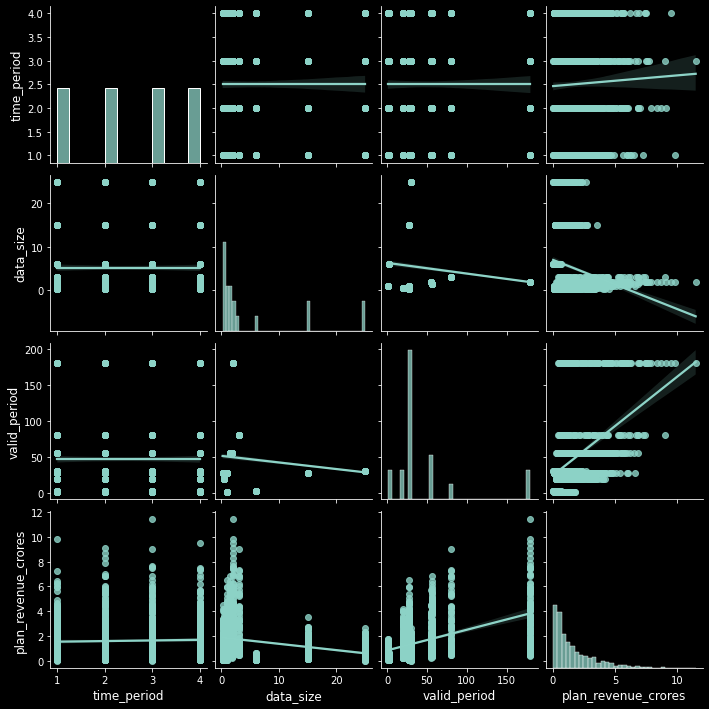

In [24]:
sns.pairplot(df, hue=y_label if CLASSIFICATION else None, kind="reg")

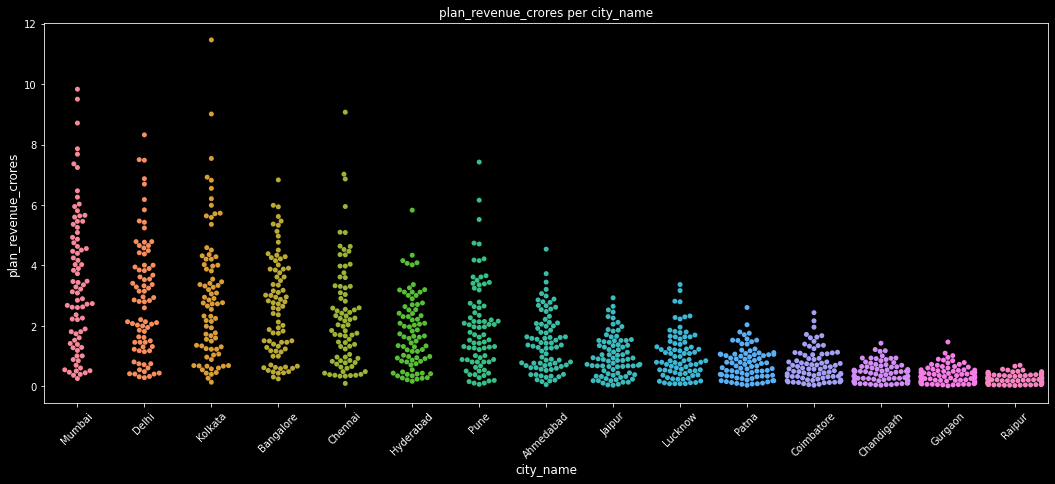

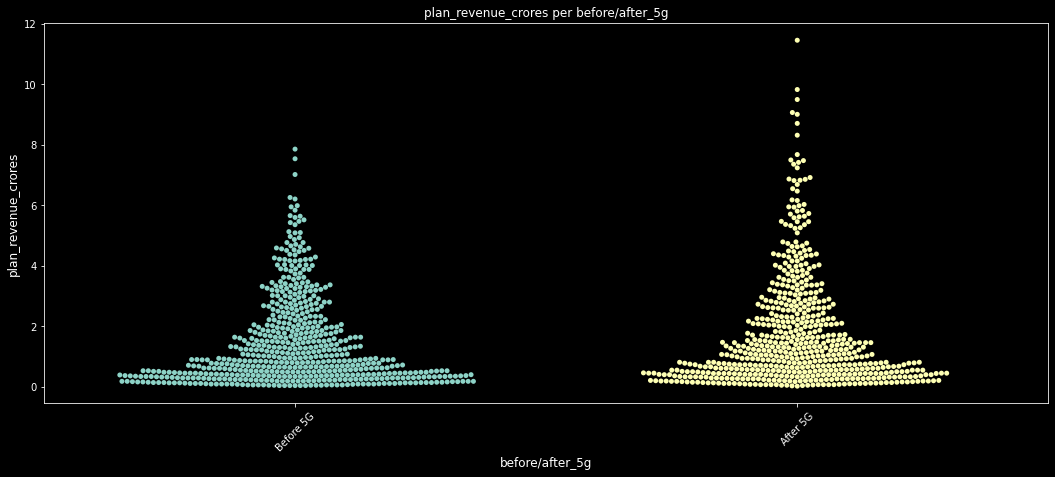

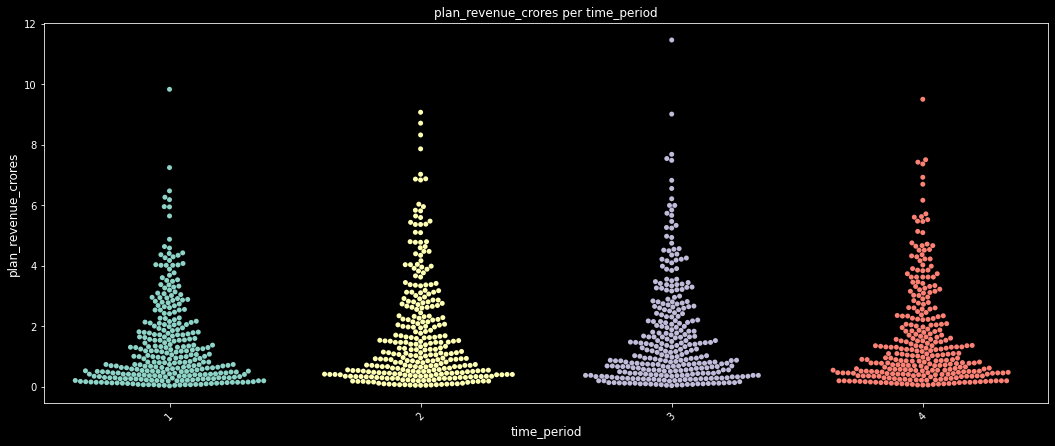

In [25]:
if CLASSIFICATION:
    for col in col_num_cont:
        fig, ax = plt.subplots()
        for y_val in df[y_label].unique():
            sns.kdeplot(
                df[df[y_label] == y_val][col],
                alpha=0.5,
                shade=True,
                label=f"{y_label}={y_val}",
                ax=ax,
            )
        plt.title(f"{col} Frequency")
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")
        ax.legend()
        plt.show()
else:
    for col in col_cat + col_num_disc:
        sns.swarmplot(x=col, y=y_label, data=df).set_title(f"{y_label} per {col}")
        plt.xticks(rotation=45)
        plt.show()

plan_revenue_crores                                          \
city_name                 Ahmedabad Bangalore Chandigarh Chennai Coimbatore   
before/after_5g                                                               
After 5G                       1.60      2.82       0.50    2.51       0.77   
Before 5G                      1.36      2.51       0.44    2.20       0.64   

                                                                             \
city_name       Delhi Gurgaon Hyderabad Jaipur Kolkata Lucknow Mumbai Patna   
before/after_5g                                                               
After 5G         3.31    0.46      2.01   1.16    3.24    1.09   3.99  0.85   
Before 5G        2.52    0.33      1.61   0.89    2.77    1.00   3.02  0.70   

                             
city_name       Pune Raipur  
before/after_5g              
After 5G        2.11   0.29  
Before 5G       1.85   0.22

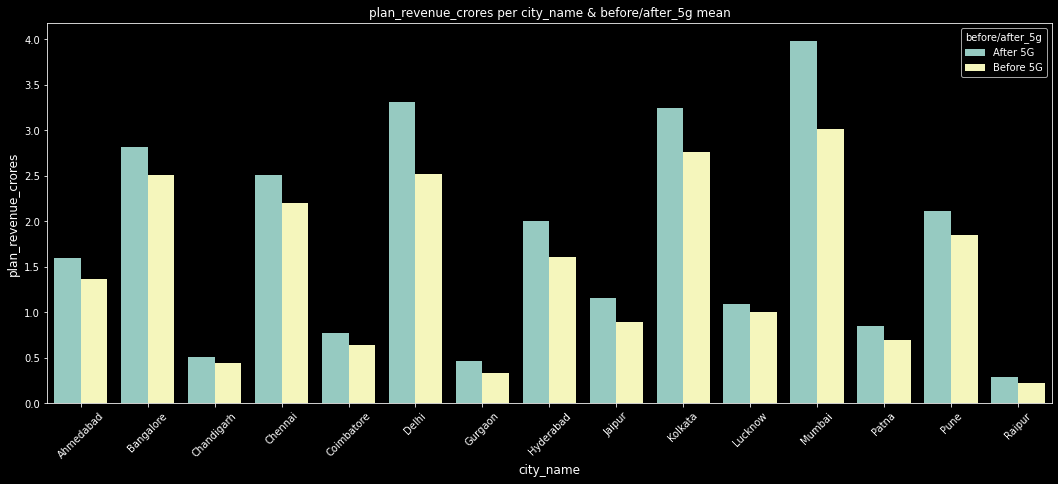

plan_revenue_crores          
before/after_5g            After 5G Before 5G
time_period                                  
1                              1.60      1.29
2                              1.87      1.60
3                              1.86      1.53
4                              1.79      1.47

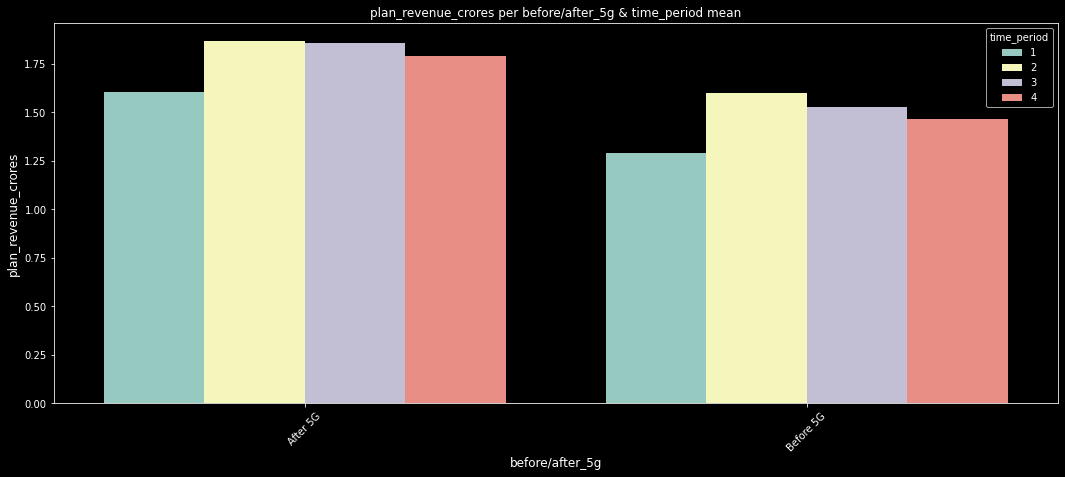

In [26]:
for col1, col2 in zip(col_cat + col_num_disc, (col_cat + col_num_disc)[1:]):
    df_plot = df[[col1, col2, y_label]].groupby([col1, col2], as_index=False).mean()
    display(df_plot.pivot(columns=col1, index=col2))
    sns.barplot(x=col1, y=y_label, hue=col2, data=df_plot).set_title(f"{y_label} per {col1} & {col2} mean")
    plt.xticks(rotation=45)
    plt.show()

Count                                                \
city_name       Ahmedabad Bangalore Chandigarh Chennai Coimbatore Delhi   
before/after_5g                                                           
After 5G               40        40         40      40         40    40   
Before 5G              40        40         40      40         40    40   

                                                                            \
city_name       Gurgaon Hyderabad Jaipur Kolkata Lucknow Mumbai Patna Pune   
before/after_5g                                                              
After 5G             40        40     40      40      40     40    40   40   
Before 5G            40        40     40      40      40     40    40   40   

                        
city_name       Raipur  
before/after_5g         
After 5G            40  
Before 5G           40

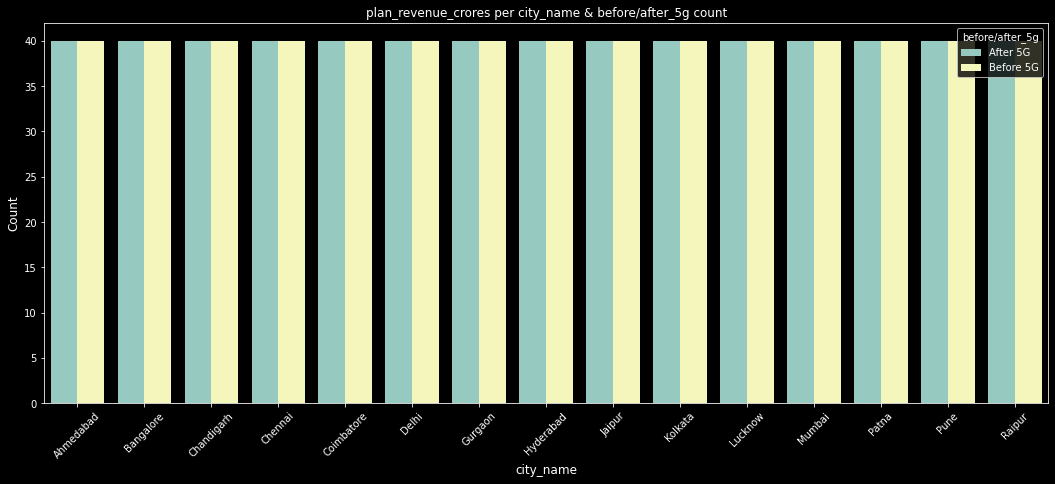

Count          
before/after_5g After 5G Before 5G
time_period                       
1                    150       150
2                    150       150
3                    150       150
4                    150       150

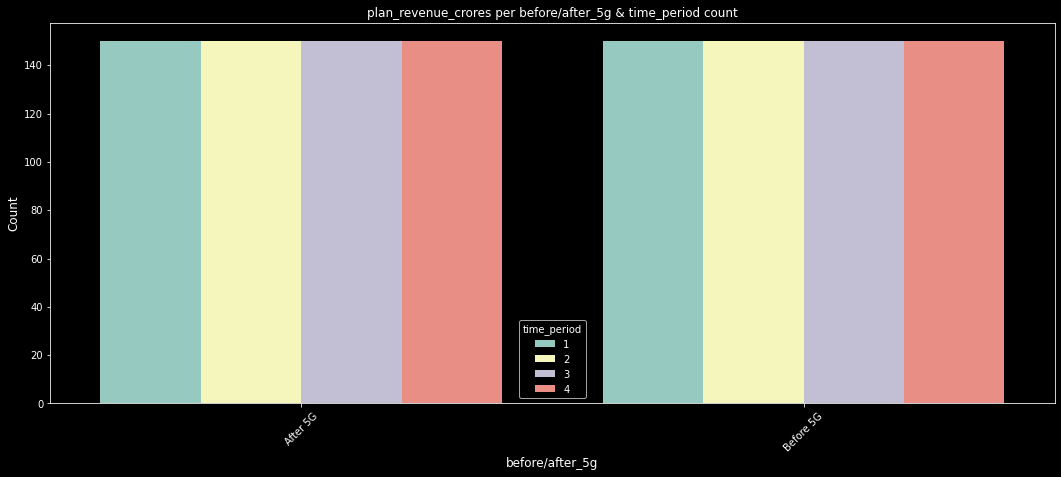

In [27]:
for col1, col2 in zip(col_cat + col_num_disc, (col_cat + col_num_disc)[1:]):
    df_plot = (
        df.groupby([col1, col2], as_index=False)
        .size()
        .rename({"size": "Count"}, axis=1)
    )
    display(df_plot.pivot(columns=col1, index=col2))
    sns.barplot(x=col1, y="Count", hue=col2, data=df_plot).set_title(f"{y_label} per {col1} & {col2} count")
    plt.xticks(rotation=45)
    plt.show()

city_name,Ahmedabad,Bangalore,Chandigarh,Chennai,Coimbatore,Delhi,Gurgaon,Hyderabad,Jaipur,Kolkata,Lucknow,Mumbai,Patna,Pune,Raipur
time_period,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50
data_size,5.16,5.16,5.16,5.16,5.16,5.16,5.16,5.16,5.16,5.16,5.16,5.16,5.16,5.16,5.16
valid_period,46.75,46.75,46.75,46.75,46.75,46.75,46.75,46.75,46.75,46.75,46.75,46.75,46.75,46.75,46.75
plan_revenue_crores,1.48,2.67,0.47,2.35,0.70,2.92,0.39,1.81,1.03,3.00,1.04,3.50,0.77,1.98,0.26


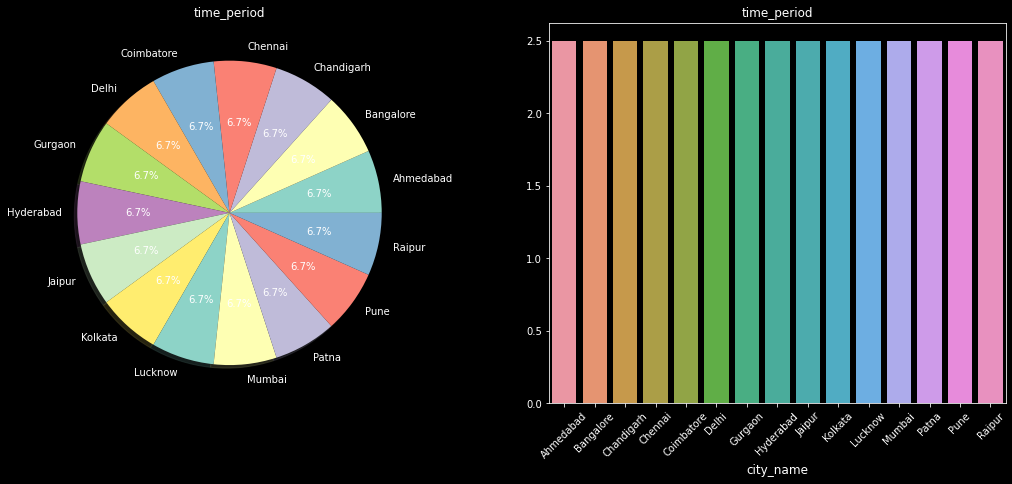

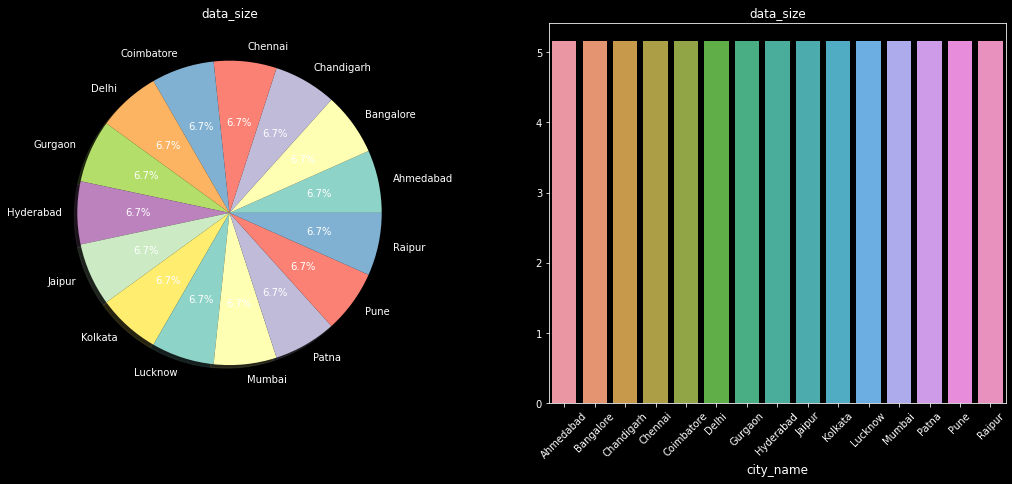

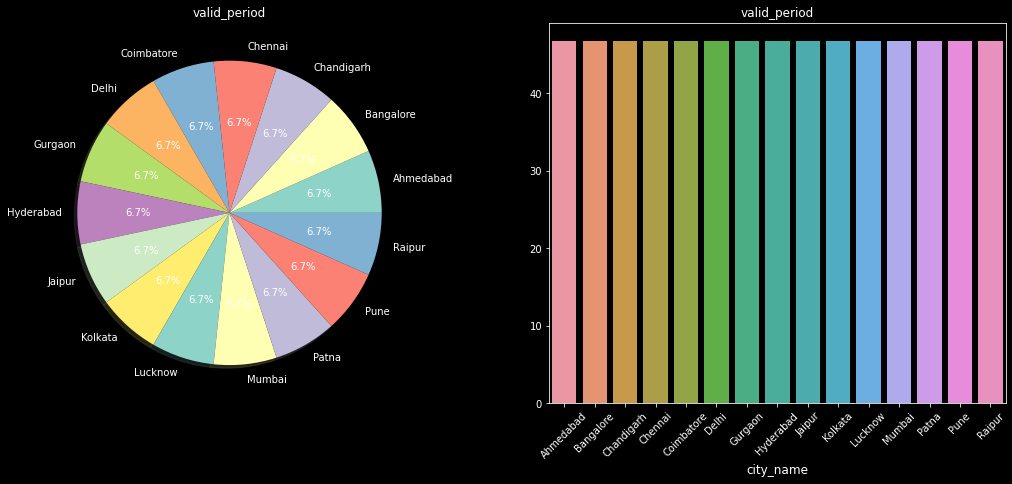

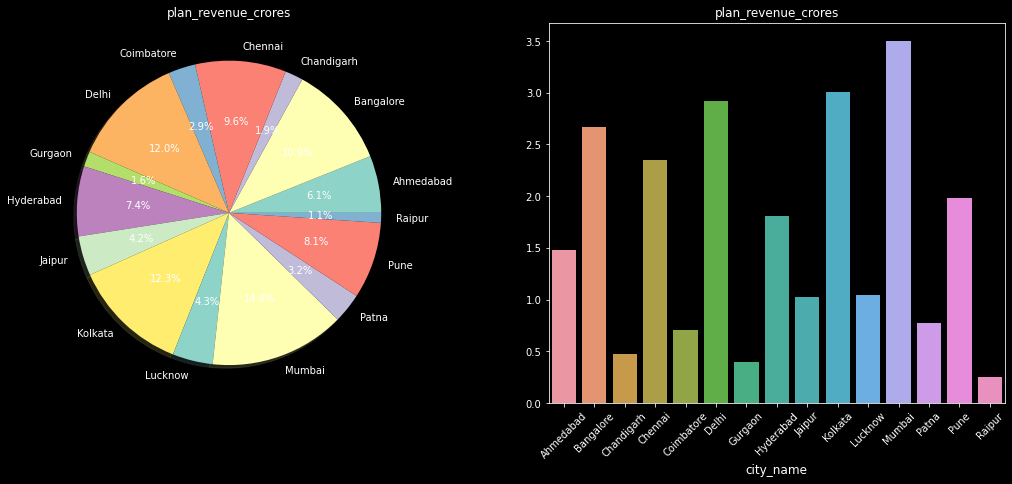

before/after_5g,After 5G,Before 5G
time_period,2.50,2.50
data_size,5.08,5.25
valid_period,53.30,40.20
plan_revenue_crores,1.78,1.47


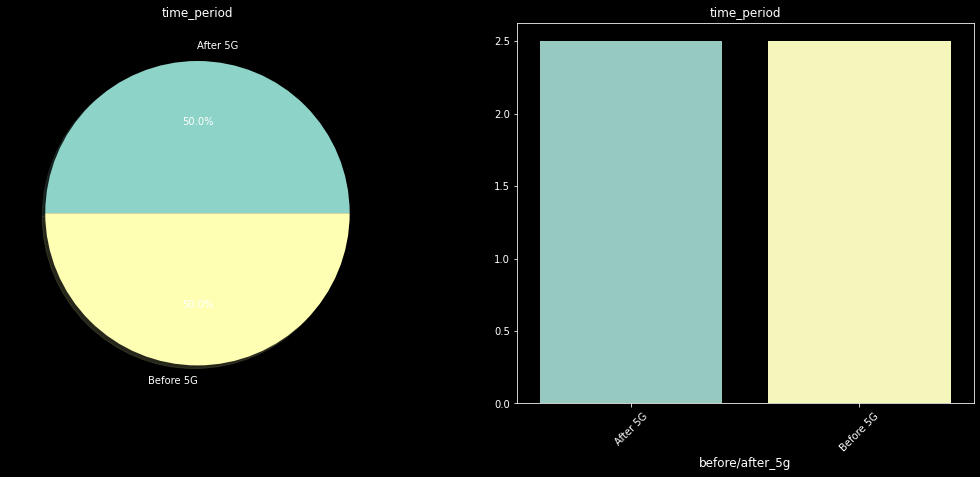

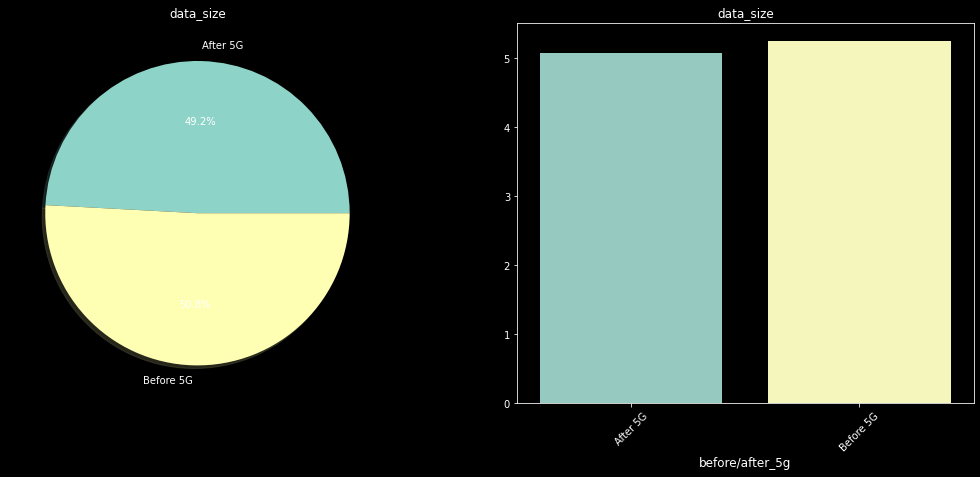

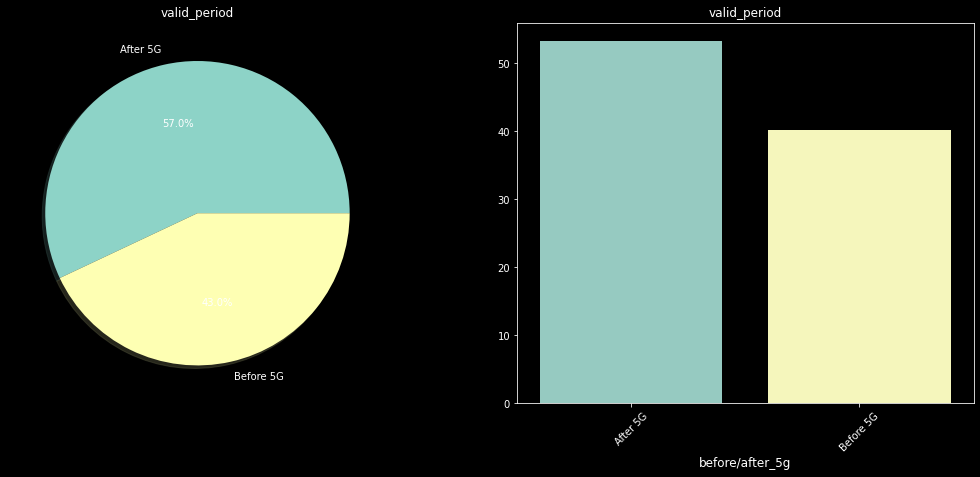

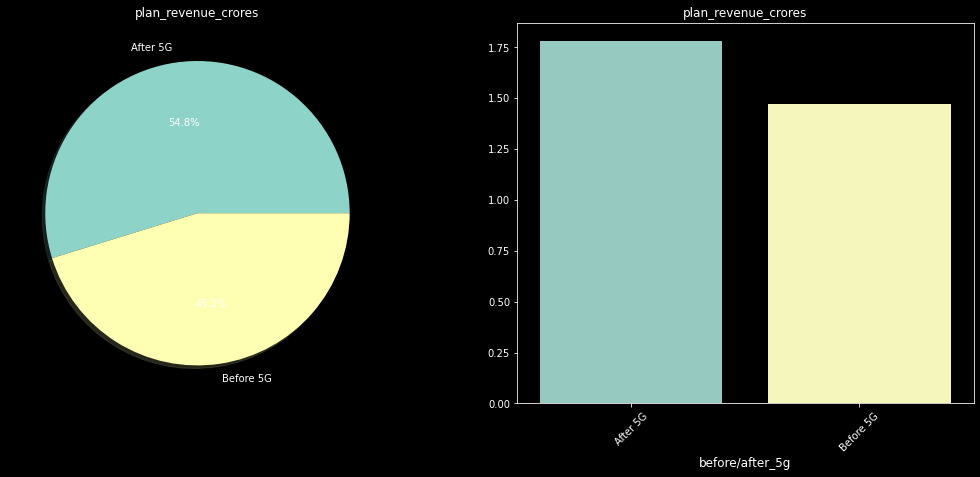

time_period,1,2,3,4
data_size,5.16,5.16,5.16,5.16
valid_period,46.75,46.75,46.75,46.75
plan_revenue_crores,1.45,1.73,1.69,1.63


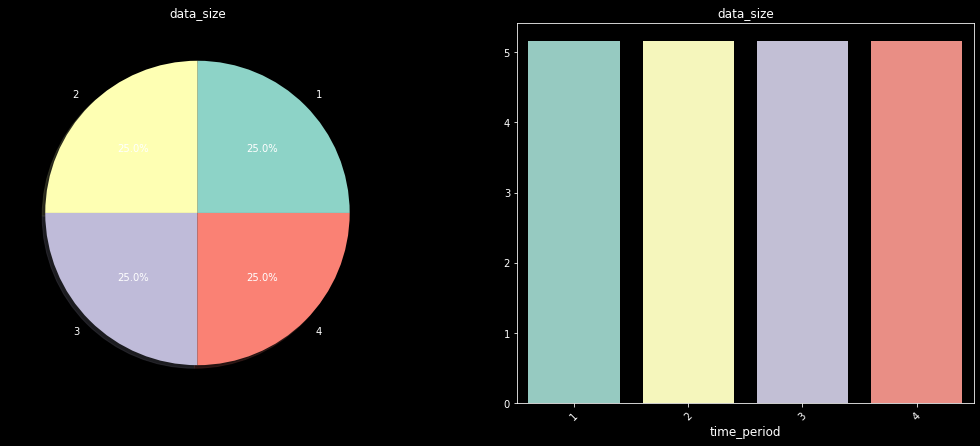

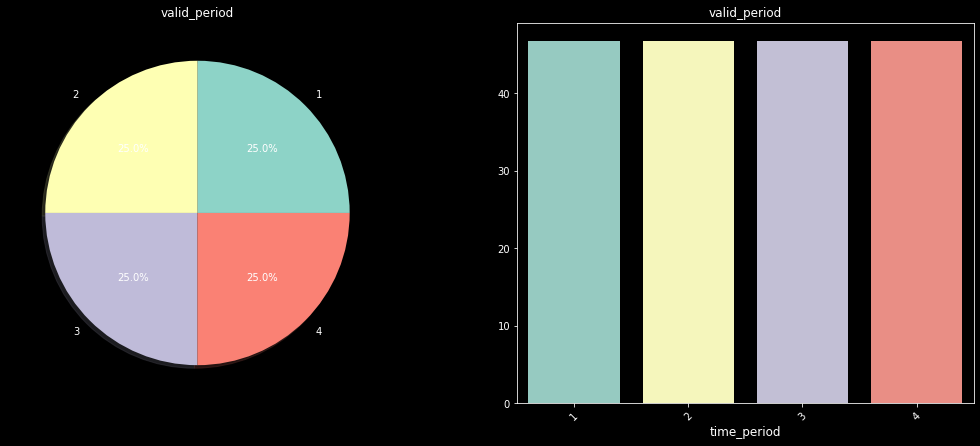

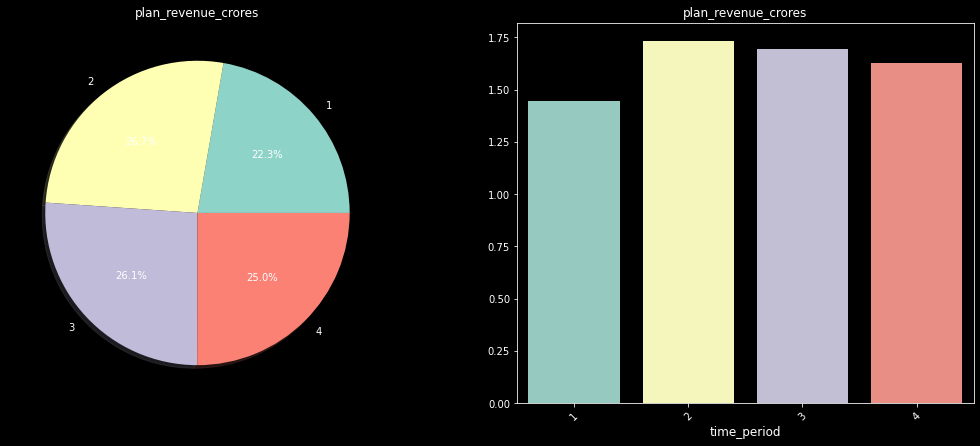

In [28]:
for col in col_cat + col_num_disc:
    df_plot = df.groupby([col]).mean().T.abs().replace({np.nan: 0})
    display(df_plot)
    for topic in df_plot.index:
        df_plot_1 = df_plot.loc[topic]
        fig, ax = plt.subplots(nrows=1, ncols=2)
        ax[0].pie(x=df_plot_1.values, autopct="%.1f%%", shadow=True, labels=df_plot_1.index)
        ax[0].set_title(topic)
        sns.barplot(x=df_plot_1.index, y=df_plot_1.values, ax=ax[1]).set_title(topic)
        plt.xticks(rotation=45)
        plt.show()

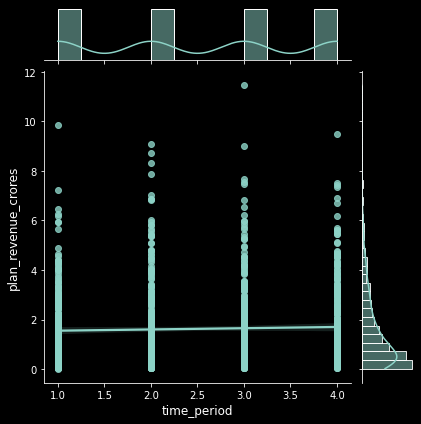

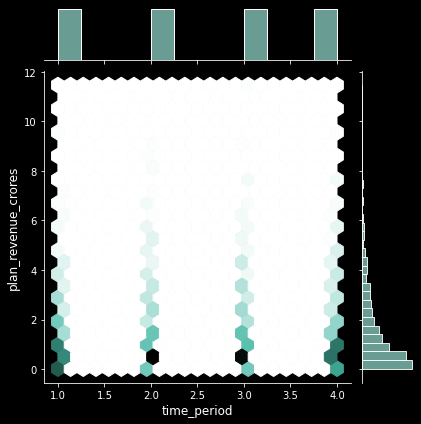

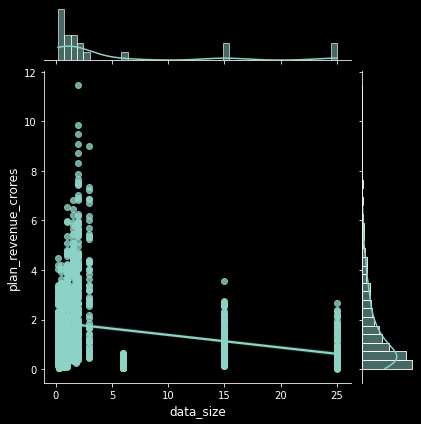

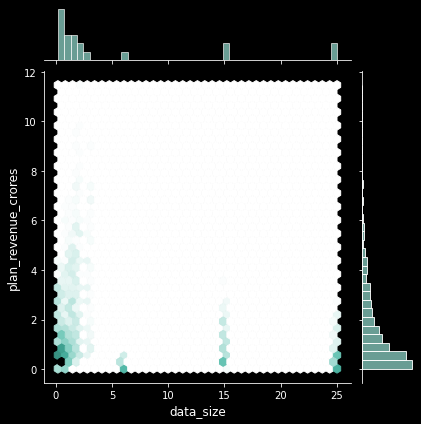

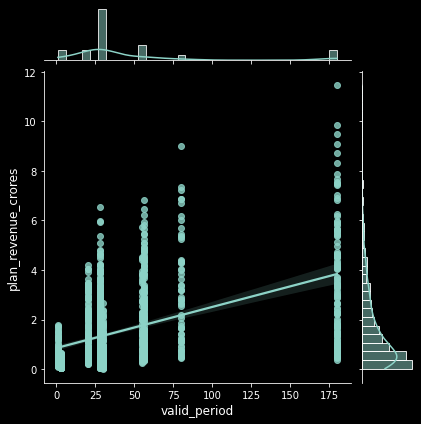

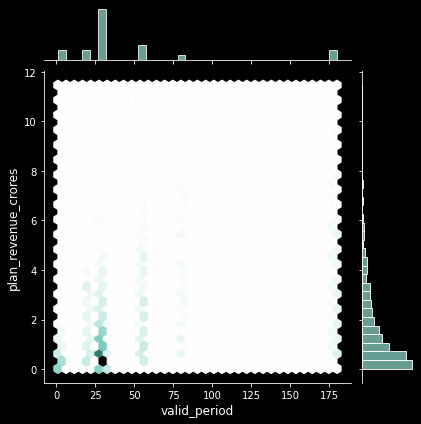

In [29]:
for col in col_num:
    if CLASSIFICATION:
        fig, ax = plt.subplots(nrows=1, ncols=1)
        sns.swarmplot(x=y_label, y=col, data=df, color="grey", alpha=0.7, ax=ax)
        sns.boxenplot(x=y_label, y=col, data=df, ax=ax)
    else:
        sns.jointplot(x=col, y=y_label, hue=None, data=df, kind="reg")
        sns.jointplot(x=col, y=y_label, hue=None, data=df, kind="hex")
    plt.show()

# Applying Boxcox Transformation

-------------------------------------------------------
Performing boxcox transformation on cols ['data_size', 'valid_period'].
Current Shape: (1200, 6).
-------------------------------------------------------
Scanning for outliers in ['data_size', 'valid_period'].
Outliers Percentage: 30.00%
-------------------------------------------------------
upper_range:
data_size       8.34
valid_period   96.12
dtype: float64
-------------------------------------------------------
lower_range:
data_size       -3.91
valid_period   -12.88
dtype: float64
-------------------------------------------------------
Outliers have been boxcox transformed (1200, 6).



-------------------------------------------------------
Performing keep transformation on cols ['city_name', 'time_period', 'data_size', 'valid_period', 'before/after_5g', 'plan_revenue_crores'].
Current Shape: (1200, 6).
-------------------------------------------------------
Scanning for outliers in ['data_size', 'valid_period', 'plan_reven

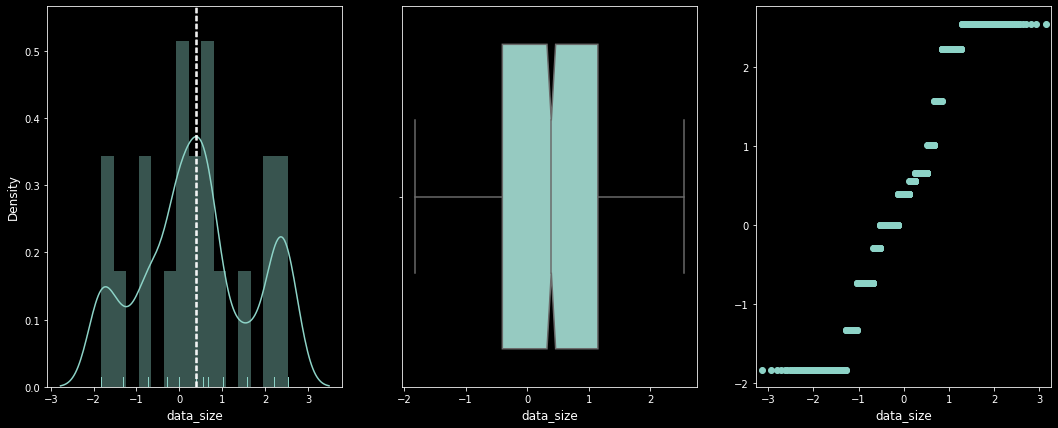

-------------------------------------------------------
valid_period
Skew: 0.08
Kurtosis: 0.98


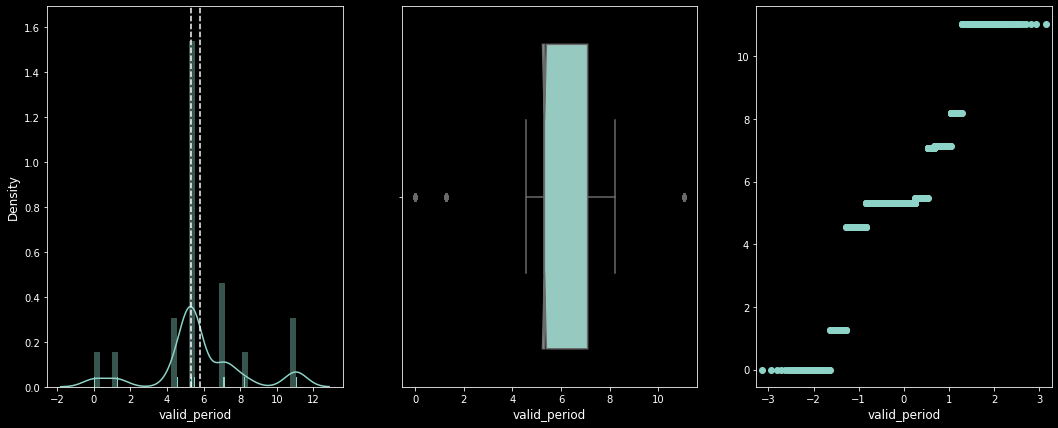

In [30]:
transformation_table = {
    "log": [],
    "log1p": [],
    "reciprocal": [],
    "sqrt": [],
    "exp": [],
    "boxcox": ["data_size", "valid_period"],
    "boxcox1": [],
    "cap": [],
    "drop": [],
    "keep": df.columns.tolist(),
}
for transform, cols in transformation_table.items():
    if cols:
        col_outlier = [col for col in col_num_cont + ([] if CLASSIFICATION else [y_label]) if col in cols]
        q1, q3 = df[col_outlier].quantile(0.25), df[col_outlier].quantile(0.75)
        iqr = q3 - q1
        lower_range, upper_range = q1 - (1.5 * iqr), q3 + (1.5 * iqr)
        condition = ~((df[col_outlier] < lower_range) | (df[col_outlier] > upper_range)).any(axis=1)
        print("-------------------------------------------------------")
        print(f"Performing {transform} transformation on cols {cols}.")
        print(f"Current Shape: {df.shape}.")
        print("-------------------------------------------------------")
        print(f"Scanning for outliers in {col_outlier}.")
        print(f"Outliers Percentage: {(df.shape[0] - df[condition].shape[0]) / df.shape[0] * 100:.2f}%")
        print("-------------------------------------------------------")
        print(f"upper_range:\n{upper_range}")
        print("-------------------------------------------------------")
        print(f"lower_range:\n{lower_range}")
        print("-------------------------------------------------------")
        if transform == "keep":
            print(f"Outliers have been kept {df.shape}.")
        elif transform == "cap":
            for col in col_outlier:
                df[col] = np.where(df[col] < lower_range[col], lower_range[col], df[col])
                df[col] = np.where(df[col] > upper_range[col], upper_range[col], df[col])
            print(f"Outliers have been capped {df.shape}.")
        elif transform == "drop":
            df = df[condition]
            print(f"Outliers have been removed {df.shape}.")
        elif transform == "log":
            for col in col_outlier:
                df[col] = np.log(df[col])
            print(f"Outliers have been log transformed {df.shape}.")
        elif transform == "log1p":
            for col in col_outlier:
                df[col] = np.log1p(df[col])
            print(f"Outliers have been log1p transformed {df.shape}.")
        elif transform == "reciprocal":
            for col in col_outlier:
                df[col] = (1 / df[col])
            print(f"Outliers have been reciprocal transformed {df.shape}.")
        elif transform == "sqrt":
            for col in col_outlier:
                df[col] = (df[col] ** 0.5)
            print(f"Outliers have been sqrt transformed {df.shape}.")
        elif transform == "exp":
            for col in col_outlier:
                df[col] = (df[col] ** (1/1.2))
            print(f"Outliers have been exp transformed {df.shape}.")
        elif transform == "boxcox":
            for col in col_outlier:
                df[col] = stat.boxcox(df[col])[0]
            print(f"Outliers have been boxcox transformed {df.shape}.")
        elif transform == "boxcox1":
            for col in col_outlier:
                df[col] = stat.boxcox(df[col] + 1)[0]
            print(f"Outliers have been boxcox1 transformed {df.shape}.")
        print("\n\n")

for col in col_num_cont:
    fig, ax = plt.subplots(nrows=1, ncols=3)
    sns.distplot(x=df[col], ax=ax[0], rug=True).set_xlabel(f"{col}")
    sns.boxplot(x=df[col], ax=ax[1], notch=True).set_xlabel(f"{col}")
    sm.qqplot(data=df[col], ax=ax[2], xlabel=col, ylabel="")
    ax[0].axvline(x=df[col].mean(), linestyle="--")
    ax[0].axvline(x=df[col].median(), linestyle="--")
    print("-------------------------------------------------------")
    print(f"{col}\nSkew: {df[col].skew(axis=0, skipna=True):.2f}\nKurtosis: {df[col].kurtosis(axis=0, skipna=True):.2f}")
    plt.show()

# Feature Engineering and Data Pipeline (Impute, OHE, Scaling, Variance Threshold, PCA)

In [31]:
X, y = df.drop([y_label], axis=1), df[y_label]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=[None, y, y][CLASSIFICATION],
    random_state=RANDOM_STATE,
)
preprocessor_cat_ohe = make_pipeline(
    (SimpleImputer(strategy="most_frequent")),
    (OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False)),
)
preprocessor_num_disc = make_pipeline(
    (KNNImputer(n_neighbors=5)),
)
preprocessor_num_cont = make_pipeline(
    (KNNImputer(n_neighbors=5)),
)
preprocessor_col = make_column_transformer(
    (preprocessor_cat_oe, col_cat_oe),
    (preprocessor_cat_ohe, col_cat_ohe),
    (preprocessor_num_disc, col_num_disc),
    (preprocessor_num_cont, col_num_cont),
    sparse_threshold=0
)
preprocessor = make_pipeline(
    (preprocessor_col),
    ([MinMaxScaler(), StandardScaler()][SCALER]),
    (VarianceThreshold(threshold=0)),
    (PCA())
)
X_train_processed, y_train_processed = preprocessor.fit_transform(X_train), y_train
X_test_processed, y_test_processed = preprocessor.transform(X_test), y_test
if CLASSIFICATION:
    class_weights = {i: w for i, w in enumerate(class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train_processed), y=y_train_processed))}
    fig, ax = plt.subplots(nrows=1, ncols=3)
    sns.despine(left=True)
    sns.countplot(y, ax=ax[0]).set_xlabel("y")
    sns.countplot(y_train, ax=ax[1]).set_xlabel("y_train")
    sns.countplot(y_train_processed, ax=ax[2]).set_xlabel("y_train_processed")
    plt.show()
    print("-------------------------------------------------------")
    print(f"class_weights: {class_weights}")
    print("-------------------------------------------------------")
    print(f"y:\n{y.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_train:\n{y_train.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_train_processed:\n{y_train_processed.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_test:\n{y_test.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_test_processed:\n{y_test_processed.value_counts(normalize=True)}")
print("-------------------------------------------------------")
print(f"col_cat_oe ({len(col_cat_oe)}): {col_cat_oe}")
print(f"col_cat_ohe ({len(col_cat_ohe)}): {col_cat_ohe}")
print(f"col_num_disc ({len(col_num_disc)}): {col_num_disc}")
print(f"col_num_cont ({len(col_num_cont)}): {col_num_cont}")
print("-------------------------------------------------------")
print(f"total cols for preprocessor: {len(col_cat_oe) + len(col_cat_ohe) + len(col_num_disc) + len(col_num_cont)}")
print("-------------------------------------------------------")
print(f"X: {X.shape}\tX_train: {X_train.shape}\tX_train_processed:{X_train_processed.shape}\tX_test: {X_test.shape}\t\tX_test_processed:{X_test_processed.shape}")
print(f"y: {y.shape}\ty_train: {y_train.shape}\t\ty_train_processed:{y_train_processed.shape}\ty_test: {y_test.shape}\t\ty_test_processed:{y_test_processed.shape}")
print("-------------------------------------------------------")

-------------------------------------------------------
col_cat_oe (0): []
col_cat_ohe (2): ['city_name', 'before/after_5g']
col_num_disc (1): ['time_period']
col_num_cont (2): ['data_size', 'valid_period']
-------------------------------------------------------
total cols for preprocessor: 5
-------------------------------------------------------
X: (1200, 5)	X_train: (960, 5)	X_train_processed:(960, 18)	X_test: (240, 5)		X_test_processed:(240, 18)
y: (1200,)	y_train: (960,)		y_train_processed:(960,)	y_test: (240,)		y_test_processed:(240,)
-------------------------------------------------------


# Building, Hyper-param Tuning ML and ANN Models

In [32]:
def build_auto_model():
    if CLASSIFICATION:
        SimpleClassifier(random_state=RANDOM_STATE).fit(clean(df), target_col=y_label)
    else:
        SimpleRegressor(random_state=RANDOM_STATE).fit(clean(df), target_col=y_label)


def build_ml_model():
    tests = [
        {
            "model": make_pipeline_imb(
                preprocessor_col,
                [MinMaxScaler(), StandardScaler()][SCALER],
                SMOTE(random_state=RANDOM_STATE),
                VarianceThreshold(threshold=0),
                PCA(),
                SelectPercentile(),
                XGBClassifier() if CLASSIFICATION else XGBRegressor(),
            )
            if OVERSAMPLE
            else make_pipeline_imb(
                preprocessor_col,
                [MinMaxScaler(), StandardScaler()][SCALER],
                VarianceThreshold(threshold=0),
                PCA(),
                SelectPercentile(),
                XGBClassifier() if CLASSIFICATION else XGBRegressor(),
            ),
            "params": {
                "columntransformer__pipeline-3__knnimputer__n_neighbors": [1, 3, 5, 7, 9],
                "columntransformer__pipeline-4__knnimputer__n_neighbors": [1, 3, 5, 7, 9],
                "selectpercentile__percentile": [i * 10 for i in range(1, 10)],
                "selectpercentile__score_func": [chi2, f_classif],
                "xgbclassifier__colsample_bytree": [0.3, 0.4, 0.5, 0.7],
                "xgbclassifier__gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
                "xgbclassifier__learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
                "xgbclassifier__max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
                "xgbclassifier__min_child_weight": [1, 3, 5, 7],
            }
            if CLASSIFICATION
            else {
                "columntransformer__pipeline-3__knnimputer__n_neighbors": [1, 3, 5, 7, 9],
                "columntransformer__pipeline-4__knnimputer__n_neighbors": [1, 3, 5, 7, 9],
                "selectpercentile__percentile": [i * 10 for i in range(1, 10)],
                "selectpercentile__score_func": [chi2, f_classif],
                "xgbregressor__colsample_bytree": [0.3, 0.4, 0.5, 0.7],
                "xgbregressor__gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
                "xgbregressor__learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
                "xgbregressor__max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
                "xgbregressor__min_child_weight": [1, 3, 5, 7],
            },
        },
    ]
    for test in tests:
        rscv = RandomizedSearchCV(
            estimator=test["model"],
            param_distributions=test["params"],
            n_jobs=-1,
            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
            if CLASSIFICATION
            else 10,
            scoring="accuracy" if CLASSIFICATION else "r2",
            n_iter=10,
            return_train_score=True,
        )
        display(rscv)
        rscv.fit(X_train, y_train)
        print("===train============================")
        print(f"{rscv.best_score_ * 100:.2f}%\n{test['model'][-1]}\n{rscv.best_params_}")
        print("===params============================")
        display(pd.DataFrame(rscv.cv_results_).sort_values(by="rank_test_score"))
        print("===test============================")
        print(f"test score:{rscv.score(X_test, y_test) * 100:.2f}%")
        print("====end===========================\n")

    build_auto_model()
    print("-------------------------------------------------------")
    if CLASSIFICATION:
        classification_report_test = classification_report(
            y_test,
            rscv.predict(X_test),
            output_dict=True,
        )
        print(f"accuracy: {classification_report_test['accuracy']:.3f} recall_macro: {classification_report_test['macro avg']['recall']:.3f} precision_macro: {classification_report_test['macro avg']['precision']:.3f} f1_macro: {classification_report_test['macro avg']['f1-score']:.3f} (Test)")
        classification_report_train = classification_report(
            y_train,
            rscv.predict(X_train),
            output_dict=True,
        )
        print(f"accuracy: {classification_report_train['accuracy']:.3f} recall_macro: {classification_report_train['macro avg']['recall']:.3f} precision_macro: {classification_report_train['macro avg']['precision']:.3f} f1_macro: {classification_report_train['macro avg']['f1-score']:.3f} (Train)")
        print("-------------------------------------------------------")
        print(
            classification_report(
                y_test,
                rscv.predict(X_test),
            )
        )
        sns.heatmap(
            tf.math.confusion_matrix(
                y_test,
                rscv.predict(X_test),
            ),
            cmap="Blues",
            fmt="d",
            annot=True,
            linewidths=1,
        )
        plt.xlabel("Predicted")
        plt.ylabel("Truth")

    else:
        print(f"r2: {r2_score(y_test, rscv.predict(X_test)):.3f} neg_mean_squared_error: -{mean_squared_error(y_test, rscv.predict(X_test)):_.3f} (Test)")
        print(f"r2: {r2_score(y_train, rscv.predict(X_train)):.3f} neg_mean_squared_error: -{mean_squared_error(y_train, rscv.predict(X_train)):_.3f} (Train)")
        print("-------------------------------------------------------")
        plt.subplot(1, 4, 1)
        sns.regplot(y_train, y_train, color="darkorange", label="Truth")
        sns.regplot(
            y_test,
            rscv.predict(X_test),
            color="darkcyan",
            label="Predicted",
        )
        plt.title(
            "Truth vs Predicted",
            fontsize=10,
        )
        plt.xlabel("Truth values")
        plt.ylabel("Predicted values")
        plt.legend()
        plt.grid()

        plt.subplot(1, 4, 2)
        sns.scatterplot(
            data=pd.DataFrame(
                {
                    "Predicted values": rscv.predict(X_train),
                    "Residuals": rscv.predict(X_train) - y_train,
                }
            ),
            x="Predicted values",
            y="Residuals",
            color="darkorange",
            marker="o",
            s=35,
            alpha=0.5,
            label="Train data",
        )
        sns.scatterplot(
            data=pd.DataFrame(
                {
                    "Predicted values": rscv.predict(X_test),
                    "Residuals": rscv.predict(X_test) - y_test,
                }
            ),
            x="Predicted values",
            y="Residuals",
            color="darkcyan",
            marker="o",
            s=35,
            alpha=0.7,
            label="Test data",
        )
        plt.title(
            "Predicted vs Residuals",
            fontsize=10,
        )
        plt.hlines(y=0, xmin=0, xmax=df[y_label].max(), lw=2, color="red")
        plt.grid()

        plt.subplot(1, 4, 3)
        sns.distplot((y_train - rscv.predict(X_train)))
        plt.title(
            "Error Terms",
            fontsize=10,
        )
        plt.xlabel("Errors")
        plt.grid()

        plt.subplot(1, 4, 4)
        sns.distplot(y_train, hist=False, color="darkorange", label="Truth")
        sns.distplot(rscv.predict(X_train), hist=False, color="darkcyan", label="Predicted",)
        plt.title("Truth vs Predicted", fontsize=10,)
        plt.xlabel(y_label)
        plt.legend()
        plt.grid()

    plt.show()

    display(
        pd.DataFrame(
            {
                "Truth": y_test[:10].values,
                "Predicted": rscv.predict(X_test[:10]).round(1),
            }
        )
    )
    return rscv


def tune_dl_model(hp):
    model = keras.models.Sequential()
    model.add(
        keras.layers.Dense(
            units=hp.Int("input_00_unit", min_value=32, max_value=512, step=32),
            input_shape=X_train_processed.shape[1:],
        )
    )
    for i in range(hp.Int("num_layers", min_value=1, max_value=64)):
        model.add(
            keras.layers.Dense(
                units=hp.Int(f"hidden_{i:02}_unit", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
        model.add(keras.layers.Dropout(hp.Float("dropout", min_value=0, max_value=0.5, step=0.1)))
    model.add(
        keras.layers.Dense(
            units=[1, 1, df[y_label].nunique()][CLASSIFICATION],
            activation=["linear", "sigmoid", "softmax"][CLASSIFICATION],
        )
    )
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        ),
        loss=["mean_squared_error", "binary_crossentropy", "sparse_categorical_crossentropy"][CLASSIFICATION],
        metrics=["mean_squared_error", "accuracy", "accuracy"][CLASSIFICATION],
    )
    return model


def train_dl_model():
    tuner.search(
        X_train_processed,
        y_train_processed,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        callbacks=[early_stop],
        epochs=MAX_TRIALS,
        validation_split=0.2,
        verbose=1,
    )
    tuner.results_summary()

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(
        X_train_processed,
        y_train_processed,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        epochs=EPOCHS,
        validation_split=0.2,
        verbose=1,
        class_weight=class_weights if OVERSAMPLE else None
    )
    val_per_epoch = history.history[
        ["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION]
    ]
    best_epoch = val_per_epoch.index([min(val_per_epoch), max(val_per_epoch), max(val_per_epoch)][CLASSIFICATION]) + 1

    plt.subplot(1, 2, 1)
    sns.lineplot(data=history.history[["mean_squared_error", "accuracy", "accuracy"][CLASSIFICATION]], color="deeppink", linewidth=2.5)
    sns.lineplot(data=history.history[["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION]], color="darkturquoise", linewidth=2.5)
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Training Accuracy", "Val Accuracy"], loc="lower right")
    plt.grid()

    plt.subplot(1, 2, 2)
    sns.lineplot(data=history.history["loss"], color="deeppink", linewidth=2.5)
    sns.lineplot(data=history.history["val_loss"], color="darkturquoise", linewidth=2.5)
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Training Loss", "Val Loss"], loc="upper right")
    plt.grid()
    plt.show()

    print(f"Best epoch: {best_epoch}")
    
    return best_epoch, best_hps


def build_dl_model(best_epoch, best_hps):
    model = tuner.hypermodel.build(best_hps)
    model.fit(
        X_train_processed,
        y_train_processed,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        epochs=best_epoch,
        validation_split=0.2,
        verbose=1,
        class_weight=class_weights if OVERSAMPLE else None
    )
    build_auto_model()
    print("-------------------------------------------------------")
    if CLASSIFICATION:
        classification_report_test = classification_report(
            y_test_processed,
            [
                model.predict(X_test_processed).round(),
                np.argmax(model.predict(X_test_processed), axis=1),
            ][CLASSIFICATION - 1],
            output_dict=True,
        )
        print(f"accuracy: {classification_report_test['accuracy']:.3f} recall_macro: {classification_report_test['macro avg']['recall']:.3f} precision_macro: {classification_report_test['macro avg']['precision']:.3f} f1_macro: {classification_report_test['macro avg']['f1-score']:.3f} (Test)")
        classification_report_train = classification_report(
            y_train_processed,
            [
                model.predict(X_train_processed).round(),
                np.argmax(model.predict(X_train_processed), axis=1),
            ][CLASSIFICATION - 1],
            output_dict=True,
        )
        print(f"accuracy: {classification_report_train['accuracy']:.3f} recall_macro: {classification_report_train['macro avg']['recall']:.3f} precision_macro: {classification_report_train['macro avg']['precision']:.3f} f1_macro: {classification_report_train['macro avg']['f1-score']:.3f} (Train)")
        print("-------------------------------------------------------")
        print(
            classification_report(
                y_test_processed,
                [
                    model.predict(X_test_processed).round(),
                    np.argmax(model.predict(X_test_processed), axis=1),
                ][CLASSIFICATION - 1],
            )
        )
        sns.heatmap(
            tf.math.confusion_matrix(
                y_test_processed,
                [
                    model.predict(X_test_processed).round(),
                    np.argmax(model.predict(X_test_processed), axis=1),
                ][CLASSIFICATION - 1],
            ),
            cmap="Blues",
            fmt="d",
            annot=True,
            linewidths=1,
        )
        plt.xlabel("Predicted")
        plt.ylabel("Truth")

    else:
        print(f"r2: {r2_score(y_test_processed, model.predict(X_test_processed).T[0]):.3f} neg_mean_squared_error: -{mean_squared_error(y_test_processed, model.predict(X_test_processed)):_.3f} (Test)")
        print(f"r2: {r2_score(y_train_processed, model.predict(X_train_processed).T[0]):.3f} neg_mean_squared_error: -{mean_squared_error(y_train_processed, model.predict(X_train_processed)):_.3f} (Train)")
        print("-------------------------------------------------------")
        plt.subplot(1, 4, 1)
        sns.regplot(y_train_processed, y_train_processed, color="darkorange", label="Truth")
        sns.regplot(
            y_test_processed,
            model.predict(X_test_processed).T[0],
            color="darkcyan",
            label="Predicted",
        )
        plt.title(
            "Truth vs Predicted",
            fontsize=10,
        )
        plt.xlabel("Truth values")
        plt.ylabel("Predicted values")
        plt.legend()
        plt.grid()

        plt.subplot(1, 4, 2)
        sns.scatterplot(
            data=pd.DataFrame(
                {
                    "Predicted values": model.predict(X_train_processed).T[0],
                    "Residuals": model.predict(X_train_processed).T[0] - y_train_processed,
                }
            ),
            x="Predicted values",
            y="Residuals",
            color="darkorange",
            marker="o",
            s=35,
            alpha=0.5,
            label="Train data",
        )
        sns.scatterplot(
            data=pd.DataFrame(
                {
                    "Predicted values": model.predict(X_test_processed).T[0],
                    "Residuals": model.predict(X_test_processed).T[0] - y_test_processed,
                }
            ),
            x="Predicted values",
            y="Residuals",
            color="darkcyan",
            marker="o",
            s=35,
            alpha=0.7,
            label="Test data",
        )
        plt.title(
            "Predicted vs Residuals",
            fontsize=10,
        )
        plt.hlines(y=0, xmin=0, xmax=df[y_label].max(), lw=2, color="red")
        plt.grid()
        
        plt.subplot(1, 4, 3)
        sns.distplot((y_train_processed - model.predict(X_train_processed).T[0]))
        plt.title(
            "Error Terms",
            fontsize=10,
        )
        plt.xlabel("Errors")
        plt.grid()

        plt.subplot(1, 4, 4)
        sns.distplot(y_train_processed, hist=False, color="darkorange", label="Truth")
        sns.distplot(model.predict(X_train_processed).T[0], hist=False, color="darkcyan", label="Predicted",)
        plt.title("Truth vs Predicted", fontsize=10,)
        plt.xlabel(y_label)
        plt.legend()
        plt.grid()

    plt.show()

    display(
        pd.DataFrame(
            {
                "Truth": y_test_processed[:10].values,
                "Predicted": [
                    model.predict(X_test_processed[:10]).T[0],
                    model.predict(X_test_processed[:10]).T[0].round(),
                    np.argmax(model.predict(X_test_processed[:10]), axis=1),
                ][CLASSIFICATION],
            }
        )
    )
    return model


if SEARCH == "hyperband":
    tuner = Hyperband(
        tune_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION],
        max_epochs=MAX_TRIALS,
        factor=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
elif SEARCH == "random":
    tuner = RandomSearch(
        tune_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION],
        max_trials=MAX_TRIALS,
        executions_per_trial=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
else:
    tuner = BayesianOptimization(
        tune_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION],
        max_trials=MAX_TRIALS,
        executions_per_trial=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=int(MAX_TRIALS/4))
tuner.search_space_summary()

Search space summary
Default search space size: 5
input_00_unit (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 64, 'step': 1, 'sampling': None}
hidden_00_unit (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


2022-11-18 01:58:28.599678: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Building ML Model with or without SMOTE

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('columntransformer',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0,
                                                                transformer_weights=None,
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('simpleimputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                                                                              copy=True,
                                                                                                              fill_value=None,
                                                                                                              missing_values=nan,
                                                                                                              strateg...
                                                                         <function f_classif at 0x7f5373d1e710>],
                                        'xgbregressor__colsample_bytree': [0.3,
                                                                           0.4,
                                                                           0.5,
                                                                           0.7],
                                        'xgbregressor__gamma': [0.0, 0.1, 0.2,
                                                                0.3, 0.4],
                                        'xgbregressor__learning_rate': [0.05,
                                                                        0.1,
                                                                        0.15,
                                                                        0.2,
                                                                        0.25,
                                                                        0.3],
                                        'xgbregressor__max_depth': [3, 4, 5, 6,
                                                                    8, 10, 12,
                                                                    15],
                                        'xgbregressor__min_child_weight': [1, 3,
                                                                           5,
                                                                           7]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='r2', verbose=0)

===train============================
77.97%
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, objective='reg:squarederror',
             predictor=None, random_state=None, reg_alpha=None, ...)
{'xgbregressor__min_child_weight': 1, 'xgbregressor__max_depth': 3, 'xgbregressor__learning_rate': 0.15, 'xgbregressor__gamma': 0.4, 'xgbregressor__colsample_bytree': 0.5, 'selectpercentile__score_func': <function

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbregressor__min_child_weight,param_xgbregressor__max_depth,param_xgbregressor__learning_rate,param_xgbregressor__gamma,param_xgbregressor__colsample_bytree,param_selectpercentile__score_func,param_selectpercentile__percentile,param_columntransformer__pipeline-4__knnimputer__n_neighbors,param_columntransformer__pipeline-3__knnimputer__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
7,0.76,0.01,0.02,0.00,1,3,0.15,0.40,0.50,<function f_classif at 0x7f5373d1e710>,80,3,1,"{'xgbregressor__min_child_weight': 1, 'xgbregr...",0.82,0.56,0.82,0.85,0.80,0.86,0.86,0.75,0.83,0.65,0.78,0.09,1,0.93,0.93,0.93,0.91,0.93,0.94,0.94,0.92,0.93,0.93,0.93,0.01
9,0.92,0.13,0.02,0.00,7,12,0.25,0.40,0.40,<function f_classif at 0x7f5373d1e710>,60,7,1,"{'xgbregressor__min_child_weight': 7, 'xgbregr...",0.80,0.43,0.80,0.87,0.80,0.86,0.77,0.71,0.82,0.62,0.75,0.13,2,0.99,0.98,0.99,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.00
0,0.76,0.01,0.02,0.00,7,5,0.20,0.20,0.70,<function f_classif at 0x7f5373d1e710>,40,9,9,"{'xgbregressor__min_child_weight': 7, 'xgbregr...",0.75,0.40,0.82,0.87,0.73,0.78,0.70,0.71,0.73,0.68,0.71,0.12,3,0.97,0.96,0.96,0.97,0.95,0.97,0.95,0.96,0.95,0.97,0.96,0.01
4,0.83,0.11,0.03,0.01,5,4,0.15,0.40,0.50,<function f_classif at 0x7f5373d1e710>,30,7,7,"{'xgbregressor__min_child_weight': 5, 'xgbregr...",0.71,0.38,0.80,0.82,0.74,0.75,0.71,0.68,0.57,0.66,0.68,0.12,4,0.92,0.91,0.94,0.91,0.92,0.93,0.91,0.92,0.88,0.94,0.92,0.02
3,0.97,0.18,0.02,0.01,3,10,0.10,0.40,0.40,<function f_classif at 0x7f5373d1e710>,30,1,7,"{'xgbregressor__min_child_weight': 3, 'xgbregr...",0.72,0.47,0.81,0.76,0.66,0.77,0.65,0.70,0.58,0.68,0.68,0.09,5,0.98,0.98,0.98,0.98,0.97,0.98,0.97,0.98,0.96,0.98,0.98,0.00
6,0.75,0.01,0.02,0.00,1,6,0.30,0.00,0.40,<function f_classif at 0x7f5373d1e710>,30,9,1,"{'xgbregressor__min_child_weight': 1, 'xgbregr...",0.69,0.42,0.76,0.74,0.63,0.78,0.70,0.68,0.54,0.62,0.66,0.10,6,1.00,1.00,1.00,1.00,1.00,1.00,0.99,1.00,0.99,1.00,1.00,0.00
1,0.03,0.00,0.00,0.00,1,15,0.10,0.10,0.30,<function chi2 at 0x7f5373d1ecb0>,40,7,3,"{'xgbregressor__min_child_weight': 1, 'xgbregr...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.03,0.01,0.00,0.00,5,12,0.20,0.20,0.70,<function chi2 at 0x7f5373d1ecb0>,60,5,9,"{'xgbregressor__min_child_weight': 5, 'xgbregr...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.03,0.00,0.00,0.00,3,15,0.25,0.40,0.30,<function chi2 at 0x7f5373d1ecb0>,50,9,1,"{'xgbregressor__min_child_weight': 3, 'xgbregr...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.03,0.00,0.00,0.00,7,8,0.10,0.30,0.40,<function chi2 at 0x7f5373d1ecb0>,70,7,3,"{'xgbregressor__min_child_weight': 7, 'xgbregr...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


===test============================
test score:75.94%
====end===========================

Running DummyRegressor(constant=None, quantile=None, strategy='mean')
r2: -0.008 neg_mean_squared_error: -2.770
=== new best DummyRegressor(constant=None, quantile=None, strategy='mean') (using r2):
r2: -0.008 neg_mean_squared_error: -2.770

Running DecisionTreeRegressor(ccp_alpha=0.0, criterion='squared_error', max_depth=1,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      random_state=11, splitter='best')
r2: 0.208 neg_mean_squared_error: -2.159
=== new best DecisionTreeRegressor(ccp_alpha=0.0, criterion='squared_error', max_depth=1,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fractio

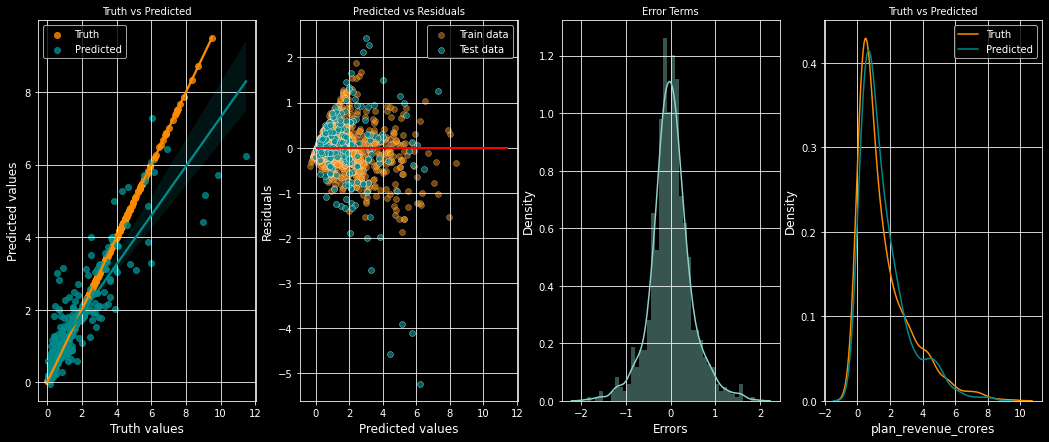

,Truth,Predicted
0,1.07,1.00
1,9.83,5.70
2,0.68,2.00
3,3.47,3.30
4,3.91,2.00
5,1.32,1.60
6,0.54,1.20
7,1.94,1.80
8,1.10,1.30
9,0.71,0.80


In [33]:
OVERSAMPLE = 0
ml_model = build_ml_model()

# Saving the Model for Deployment

In [34]:
dump(ml_model, open(f"ml_model_{time_stamp}.pkl", "wb"))

# Building Artificial Neural Network Model

Trial 30 Complete [00h 00m 02s]
val_mean_squared_error: 0.818886935710907

Best val_mean_squared_error So Far: 0.818886935710907
Total elapsed time: 00h 03m 10s
Results summary
Results in ./keras_tuner
Showing 10 best trials
Trial summary
Hyperparameters:
input_00_unit: 224
num_layers: 2
hidden_00_unit: 416
dropout: 0.30000000000000004
learning_rate: 0.001
hidden_01_unit: 480
hidden_02_unit: 416
hidden_03_unit: 64
hidden_04_unit: 128
hidden_05_unit: 96
hidden_06_unit: 416
hidden_07_unit: 256
hidden_08_unit: 128
hidden_09_unit: 416
hidden_10_unit: 192
hidden_11_unit: 384
hidden_12_unit: 64
hidden_13_unit: 480
hidden_14_unit: 32
hidden_15_unit: 128
hidden_16_unit: 192
hidden_17_unit: 32
hidden_18_unit: 384
hidden_19_unit: 352
hidden_20_unit: 96
hidden_21_unit: 96
hidden_22_unit: 192
hidden_23_unit: 224
hidden_24_unit: 192
hidden_25_unit: 224
hidden_26_unit: 416
hidden_27_unit: 160
hidden_28_unit: 96
hidden_29_unit: 128
hidden_30_unit: 128
hidden_31_unit: 480
hidden_32_unit: 128
hidden_33

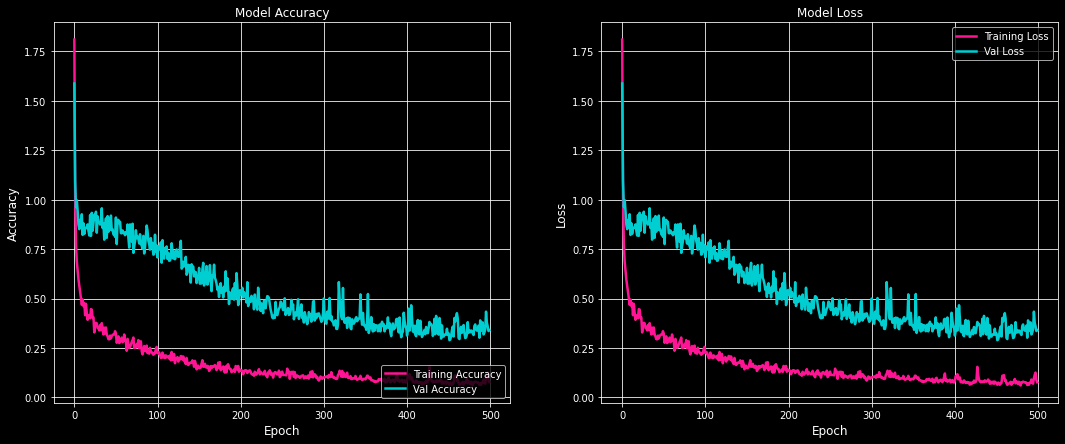

Best epoch: 452
Epoch 1/452
12/12 [==============================] - 1s 22ms/step - loss: 1.9922 - mean_squared_error: 1.9922 - val_loss: 1.4801 - val_mean_squared_error: 1.4801
Epoch 2/452
12/12 [==============================] - 0s 9ms/step - loss: 0.9072 - mean_squared_error: 0.9072 - val_loss: 1.0801 - val_mean_squared_error: 1.0801
Epoch 3/452
12/12 [==============================] - 0s 9ms/step - loss: 0.7291 - mean_squared_error: 0.7291 - val_loss: 1.0343 - val_mean_squared_error: 1.0343
Epoch 4/452
12/12 [==============================] - 0s 9ms/step - loss: 0.6332 - mean_squared_error: 0.6332 - val_loss: 0.9685 - val_mean_squared_error: 0.9685
Epoch 5/452
12/12 [==============================] - 0s 9ms/step - loss: 0.6344 - mean_squared_error: 0.6344 - val_loss: 0.8946 - val_mean_squared_error: 0.8946
Epoch 6/452
12/12 [==============================] - 0s 10ms/step - loss: 0.5484 - mean_squared_error: 0.5484 - val_loss: 0.8511 - val_mean_squared_error: 0.8511
Epoch 7/452
12/1

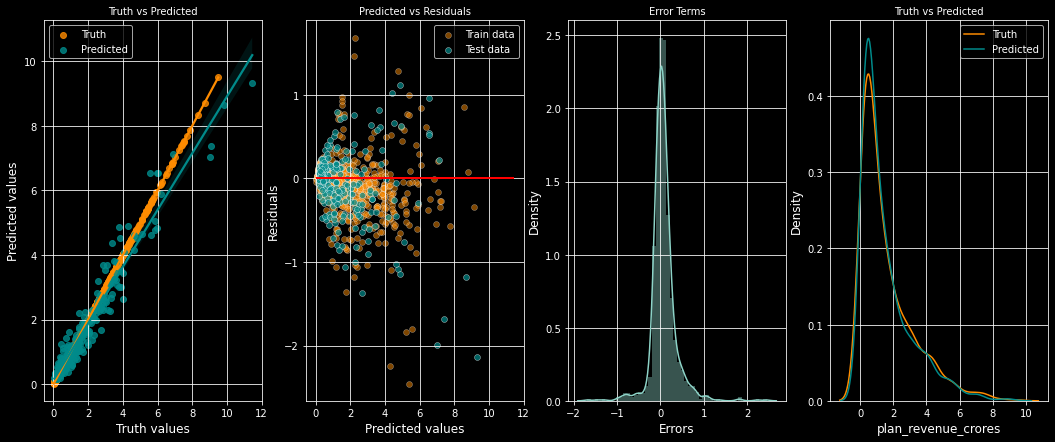

,Truth,Predicted
0,1.07,1.19
1,9.83,8.65
2,0.68,0.72
3,3.47,3.81
4,3.91,3.00
5,1.32,1.44
6,0.54,0.65
7,1.94,1.29
8,1.10,0.92
9,0.71,0.84


In [35]:
OVERSAMPLE = 0
dl_model = build_dl_model(*train_dl_model())

# Saving the Model for Deployment

2022-11-18 02:03:56.105107: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 224)               4256      
_________________________________________________________________
dense_9 (Dense)              (None, 416)               93600     
_________________________________________________________________
dropout_4 (Dropout)          (None, 416)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 480)               200160    
_________________________________________________________________
dropout_5 (Dropout)          (None, 480)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 481       
Total params: 298,497
Trainable params: 298,497
Non-trainable params: 0
________________________________________________

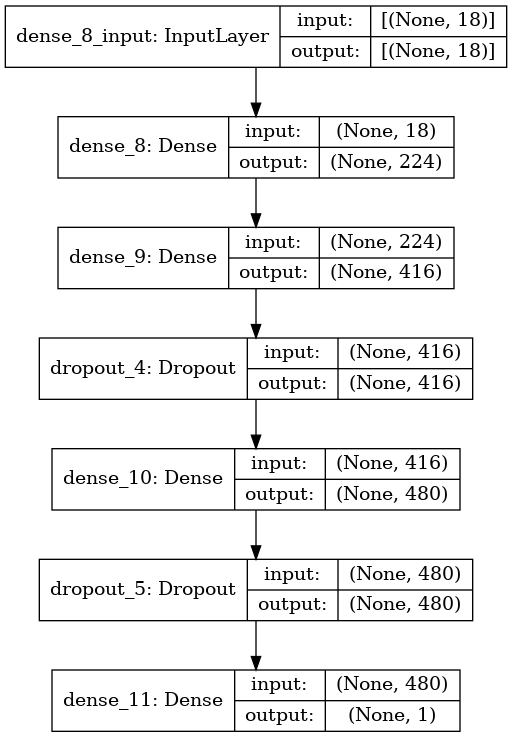

In [36]:
dl_model.save(f"dl_model_{time_stamp}")
shutil.make_archive(f"dl_model_{time_stamp}", "zip", f"./dl_model_{time_stamp}")
dump(preprocessor, open(f"preprocessor.pkl", "wb"))
dl_model.summary()
plot_model(dl_model, show_shapes=True)